# Spark traces analysis and modeling

This notebook contains a analysis of sparks application straces.

## Goal

We want to generate job profiles throught a simple job modele for Big Data applications, in order to run simulation using Batsim.

The modele design is discuss in the folowing [document](README.md). It is based on the application stages, where a job is a sequence of stages.

## Inputs and outputs

The output of this notebook is directory that contains Spark application's Events Logs.
It also uses two outside scripts:

1. [spark_result_to_batsim_csv.py](): To parse the logs and generate dataframes
2. [json_workload_generator.py](): To generate the workload from the jobs profiles generated internaly


## Loading dependencies

First loads and configure external tools with autoreload: so if you modify the underlying scripts the new version will be automatically used.

In [2]:
%load_ext autoreload
%autoreload 2 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 15, 8
import matplotlib.pyplot as plt

# Located on the same folder as this notebook
import spark_result_to_batsim_csv

## Loading inputs

**WARNING**: This takes time are requires the original traces. Avoid it of you already have the output csv files.

The traces are generated by running BDA applications on a cluster in good conditions and extract the application logs from it. This was done using the Bebida project experiment script `bebida/experiments/run_big_data_workload run_replay_workload.py` with `expe_graphene_one_time_each.json` in input.

The project is here https://gitlab.inria.fr/mmercier/bebida
It was run at Git revision 0e99baea526ca5444abc0653b361d4f20c493266

Then load the Spark application files and clean some fields (make time consitent over the different metrics).

In [3]:
pwd = %pwd
!mkdir p {pwd}/data
!cd {pwd}/data && wget -c -O - \
    https://gitlab.inria.fr/mmercier/bebida/raw/master/experiments/run_big_data_workload/results/app_logs.tar.gz | tar xzC .

mkdir: cannot create directory 'p': File exists
mkdir: cannot create directory '/home/mmercier/Projects/bebida-on-batsim/experiments/BDA_workload_generation/data': File exists
--2019-02-15 10:30:31--  https://gitlab.inria.fr/mmercier/bebida/raw/master/experiments/run_big_data_workload/results/app_logs.tar.gz
Resolving gitlab.inria.fr (gitlab.inria.fr)... 128.93.193.8
Connecting to gitlab.inria.fr (gitlab.inria.fr)|128.93.193.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23998292 (23M) [application/x-gzip]
Saving to: 'STDOUT'

-                   100%[===================>]  22.89M  10.9MB/s    in 2.1s    

2019-02-15 10:30:33 (10.9 MB/s) - written to stdout [23998292/23998292]



In [4]:
eventLogDir = f"{pwd}/data/app_logs"
!ls {eventLogDir}

application_1543954727058_0001	application_1543954727058_0006	apps.csv
application_1543954727058_0002	application_1543954727058_0007	events.csv
application_1543954727058_0003	application_1544104813447_0001	stages.csv
application_1543954727058_0004	application_1544104813447_0002	tasks.csv
application_1543954727058_0005	application_1544444660638_0001


In [5]:

events, stages, apps, tasks = spark_result_to_batsim_csv.compute_results(eventLogDir, "app*_????", None)         

   INFO: Application log directory: /home/mmercier/Projects/bebida-on-batsim/experiments/BDA_workload_generation/data/app_logs
   INFO: Get events from /home/mmercier/Projects/bebida-on-batsim/experiments/BDA_workload_generation/data/app_logs/application_1543954727058_0003
   INFO: Get events from /home/mmercier/Projects/bebida-on-batsim/experiments/BDA_workload_generation/data/app_logs/application_1543954727058_0001
   INFO: Get events from /home/mmercier/Projects/bebida-on-batsim/experiments/BDA_workload_generation/data/app_logs/application_1544104813447_0002
   INFO: Get events from /home/mmercier/Projects/bebida-on-batsim/experiments/BDA_workload_generation/data/app_logs/application_1543954727058_0007
   INFO: Get events from /home/mmercier/Projects/bebida-on-batsim/experiments/BDA_workload_generation/data/app_logs/application_1543954727058_0004
   INFO: Get events from /home/mmercier/Projects/bebida-on-batsim/experiments/BDA_workload_generation/data/app_logs/application_1544444660

In [6]:
# Store the traces to avoid reextract everything
events.to_csv(f"{eventLogDir}/events.csv")
stages.to_csv(f"{eventLogDir}/stages.csv")
apps.to_csv(f"{eventLogDir}/apps.csv")
tasks.to_csv(f"{eventLogDir}/tasks.csv")

# Analysis

This is the traces analysis part. Data consistency is check and a preliminary reflexion is done to justify the model design. 

Fore dataframes are extracted from the raw traces:
1. events
2. stages
3. apps
4. tasks



In [7]:
# Get data from csv if not set
import pandas
try:
    events
except:
    events = pandas.read_csv(f"{eventLogDir}/events.csv", index_col=0)
try:
    stages
except:
    stages = pandas.read_csv(f"{eventLogDir}/stages.csv", index_col=0)
try:
    apps
except:
    apps = pandas.read_csv(f"{eventLogDir}/apps.csv", index_col=0)
try:
    tasks
except:
    tasks = pandas.read_csv(f"{eventLogDir}/tasks.csv", index_col=[0,1,2])

## Tasks analysis

First add fix values and add metadata:

In [8]:
# put metrics in nanoseconds
tasks["Executor Run Time"] = tasks["Executor Run Time"] * 1e6
tasks["JVM GC Time"] = tasks["JVM GC Time"] * 1e6
tasks.index.names = ['AppID', 'Stage', 'Task']
tasks

Disk Bytes Spilled  \
AppID                          Stage Task                      
application_1543954727058_0003 0     0                     0   
                                     1                     0   
                                     2                     0   
                                     3                     0   
                                     4                     0   
                                     5                     0   
                                     6                     0   
                                     7                     0   
                                     8                     0   
                                     9                     0   
                                     10                    0   
                                     11                    0   
                                     12                    0   
                                     13                    0   
                                     14                    0   
                                     15                    0   
                                     16                    0   
                                     17                    0   
                                     18                    0   
                                     19                    0   
                                     20                    0   
                                     21                    0   
                                     22                    0   
                                     23                    0   
                                     24                    0   
                                     25                    0   
                                     26                    0   
                                     27                    0   
                                     28                    0   
                                     29                    0   
...                                                      ...   
application_1543954727058_0005 0     482                   0   
                                     483                   0   
                                     484                   0   
                                     485                   0   
                                     486                   0   
                                     487                   0   
                                     488                   0   
                                     489                   0   
                                     490                   0   
                                     491                   0   
                                     492                   0   
                                     493                   0   
                                     494                   0   
                                     495                   0   
                                     496                   0   
                                     497                   0   
                                     498                   0   
                                     499                   0   
                                     500                   0   
                                     501                   0   
                                     502                   0   
                                     503                   0   
                                     504                   0   
                                     505                   0   
                                     506                   0   
                                     507                   0   
                                     508                   0   
                                     509                   0   
                                     510                   0   
                                     511                   0   

         

In [9]:
list(tasks.columns)

['Disk Bytes Spilled',
 'Executor CPU Time',
 'Executor Deserialize CPU Time',
 'Executor Deserialize Time',
 'Executor Run Time',
 'Input Metrics Bytes Read',
 'Input Metrics Records Read',
 'JVM GC Time',
 'Launch Time',
 'Locality',
 'Memory Bytes Spilled',
 'Output Metrics Bytes Written',
 'Output Metrics Records Written',
 'Result Serialization Time',
 'Result Size',
 'Shuffle Read Metrics Fetch Wait Time',
 'Shuffle Read Metrics Local Blocks Fetched',
 'Shuffle Read Metrics Local Bytes Read',
 'Shuffle Read Metrics Remote Blocks Fetched',
 'Shuffle Read Metrics Remote Bytes Read',
 'Shuffle Read Metrics Total Records Read',
 'Shuffle Write Metrics Shuffle Bytes Written',
 'Shuffle Write Metrics Shuffle Records Written',
 'Shuffle Write Metrics Shuffle Write Time',
 'Updated Blocks']

In [10]:
# Locality % of bytes read localy
shuffle_read_tasks_remote = tasks[tasks['Shuffle Read Metrics Remote Bytes Read'] > 0]
shuffle_read_tasks_local = tasks[tasks['Shuffle Read Metrics Remote Bytes Read'] > 0]
shuffle_read_tasks_both = tasks[tasks['Shuffle Read Metrics Local Bytes Read' and 'Shuffle Read Metrics Remote Bytes Read'] > 0]

print(f"nb task with remote read = {shuffle_read_tasks_remote.size}")
print(f"nb task with local read = {shuffle_read_tasks_local.size}")
print(f"nb task both local and remote read = {shuffle_read_tasks_both.size}")


nb task with remote read = 47600
nb task with local read = 47600
nb task both local and remote read = 47600


In [11]:
(shuffle_read_tasks_both['Shuffle Read Metrics Local Bytes Read'] / shuffle_read_tasks_both['Shuffle Read Metrics Remote Bytes Read']).mean()

0.08997434850430425

In [12]:
# Inputs data in GB per application
tasks['Input Metrics Bytes Read'].groupby(['AppID']).sum()/1014/1024/1024

AppID
application_1543954727058_0001      31.688127
application_1543954727058_0002      63.267056
application_1543954727058_0003     126.638856
application_1543954727058_0004      31.688127
application_1543954727058_0005      63.267056
application_1543954727058_0006     126.638856
application_1543954727058_0007     426.862336
application_1544104813447_0001     426.707170
application_1544104813447_0002     855.008650
application_1544444660638_0001    1725.260838
Name: Input Metrics Bytes Read, dtype: float64

In [13]:
# Inputs data in GB per stages
tasks['Input Metrics Bytes Read'].groupby(['AppID','Stage']).sum()/1014/1024/1024

AppID                           Stage
application_1543954727058_0001  0         31.688127
                                1          0.000000
application_1543954727058_0002  0         63.267056
                                1          0.000000
application_1543954727058_0003  0        126.638856
                                1          0.000000
application_1543954727058_0004  0         31.688127
application_1543954727058_0005  0         63.267056
application_1543954727058_0006  0        126.638856
application_1543954727058_0007  0         65.218528
                                1         32.609264
                                2         68.160431
                                3         32.609264
                                4         32.609264
                                5         32.609264
                                6         32.609264
                                7          0.000000
                                8         32.609264
                          

In [80]:
# Shuffle data in GB
shuffl_col = [col for col in tasks.columns if "Byte" in col and "Remote" in col ]

shuffle_in_gb = tasks[shuffl_col].groupby(['AppID','Stage']).sum()/1014/1024/1024
shuffle_in_gb

Shuffle Read Metrics Remote Bytes Read
AppID                          Stage                                        
application_1543954727058_0001 0                                    0.000000
                               1                                    0.021228
application_1543954727058_0002 0                                    0.000000
                               1                                    0.049867
application_1543954727058_0003 0                                    0.000000
                               1                                    0.120681
application_1543954727058_0004 0                                    0.000000
application_1543954727058_0005 0                                    0.000000
application_1543954727058_0006 0                                    0.000000
application_1543954727058_0007 0                                    0.000000
                               1                                    0.000000
                               2                                    0.000000
                               3                                    0.000000
                               4                                    0.000000
                               5                                    0.000000
                               6                                    0.000000
                               7                                    0.000009
                               8                                    0.000000
                               9                                    0.000074
                               10                                   0.000000
                               11                                   0.000071
                               12                                   0.000000
                               13                                   0.000073
                               14                                   0.000000
application_1544104813447_0001 0                                    0.000000
                               1                                    0.000000
                               2                                    0.000000
                               3                                    0.000000
                               4                                    0.000000
                               5                                    0.000000
...                                                                      ...
application_1544104813447_0002 0                                    0.000000
                               1                                    0.000000
                               2                                    0.000000
                               3                                    0.000000
                               4                                    0.000000
                               5                                    0.000000
                               6                                    0.000000
                               7                                    0.000022
                               8                                    0.000000
                               9                                    0.000166
                               10                                   0.000000
                               11                                   0.000166
                               12                                   0.000000
                               13                                   0.000166
                               14                                   0.000000
application_1544444660638_0001 0                                    0.000000
                               1                                    0.000000
                               2                                    0.000000
                               3                                    0.000000
                               4  

In [81]:
shuffle_in_gb.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bac9b7b38>]],
      dtype=object)

We can observe that the shuffle phase data movement is very small regarding to the input/output data size:
always inferior to 100 MB.

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000., 18000.]), <a list of 11 Text xticklabel objects>)

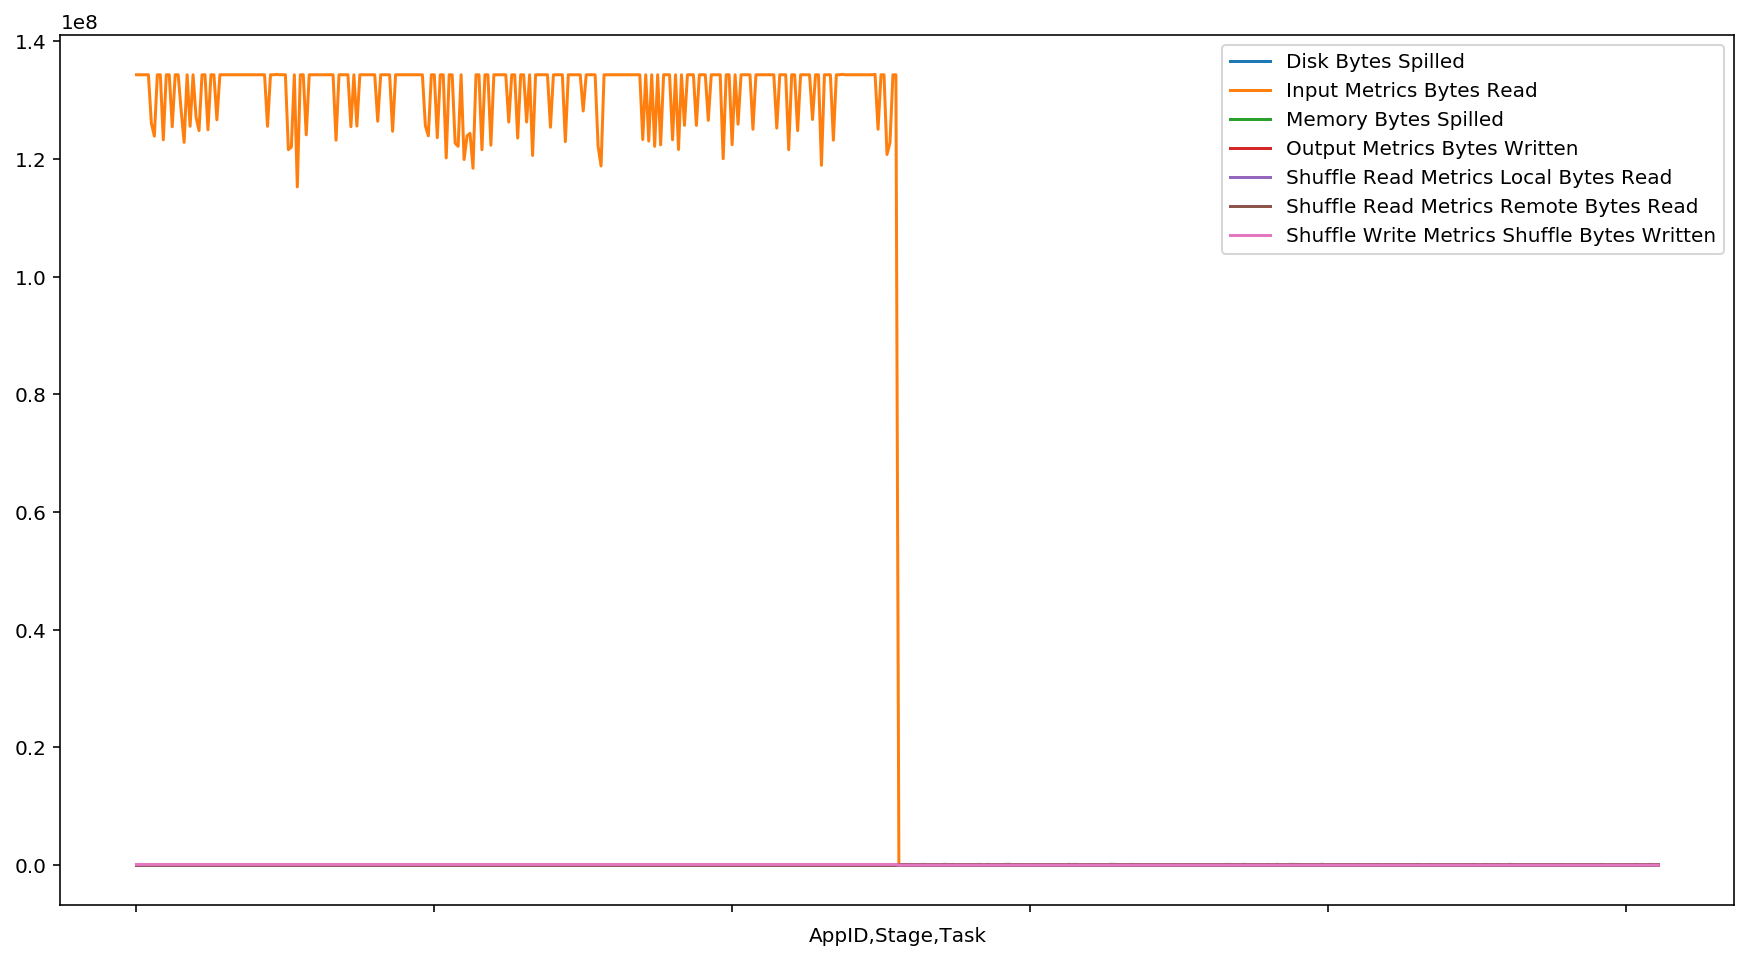

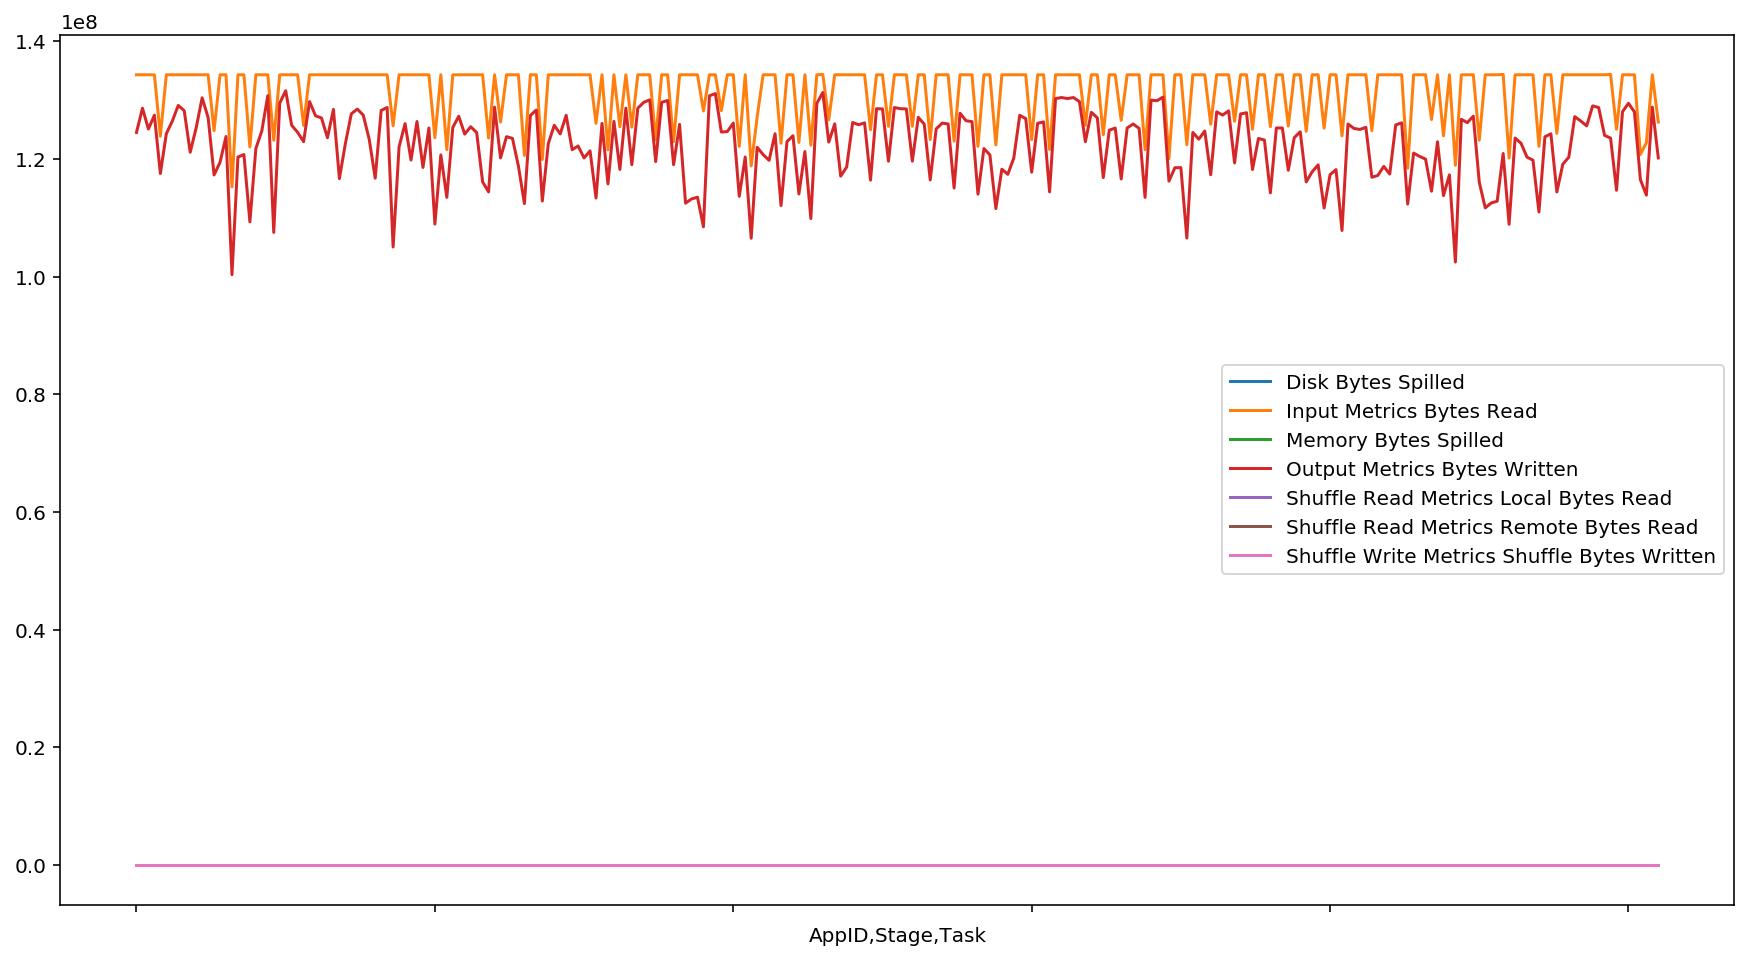

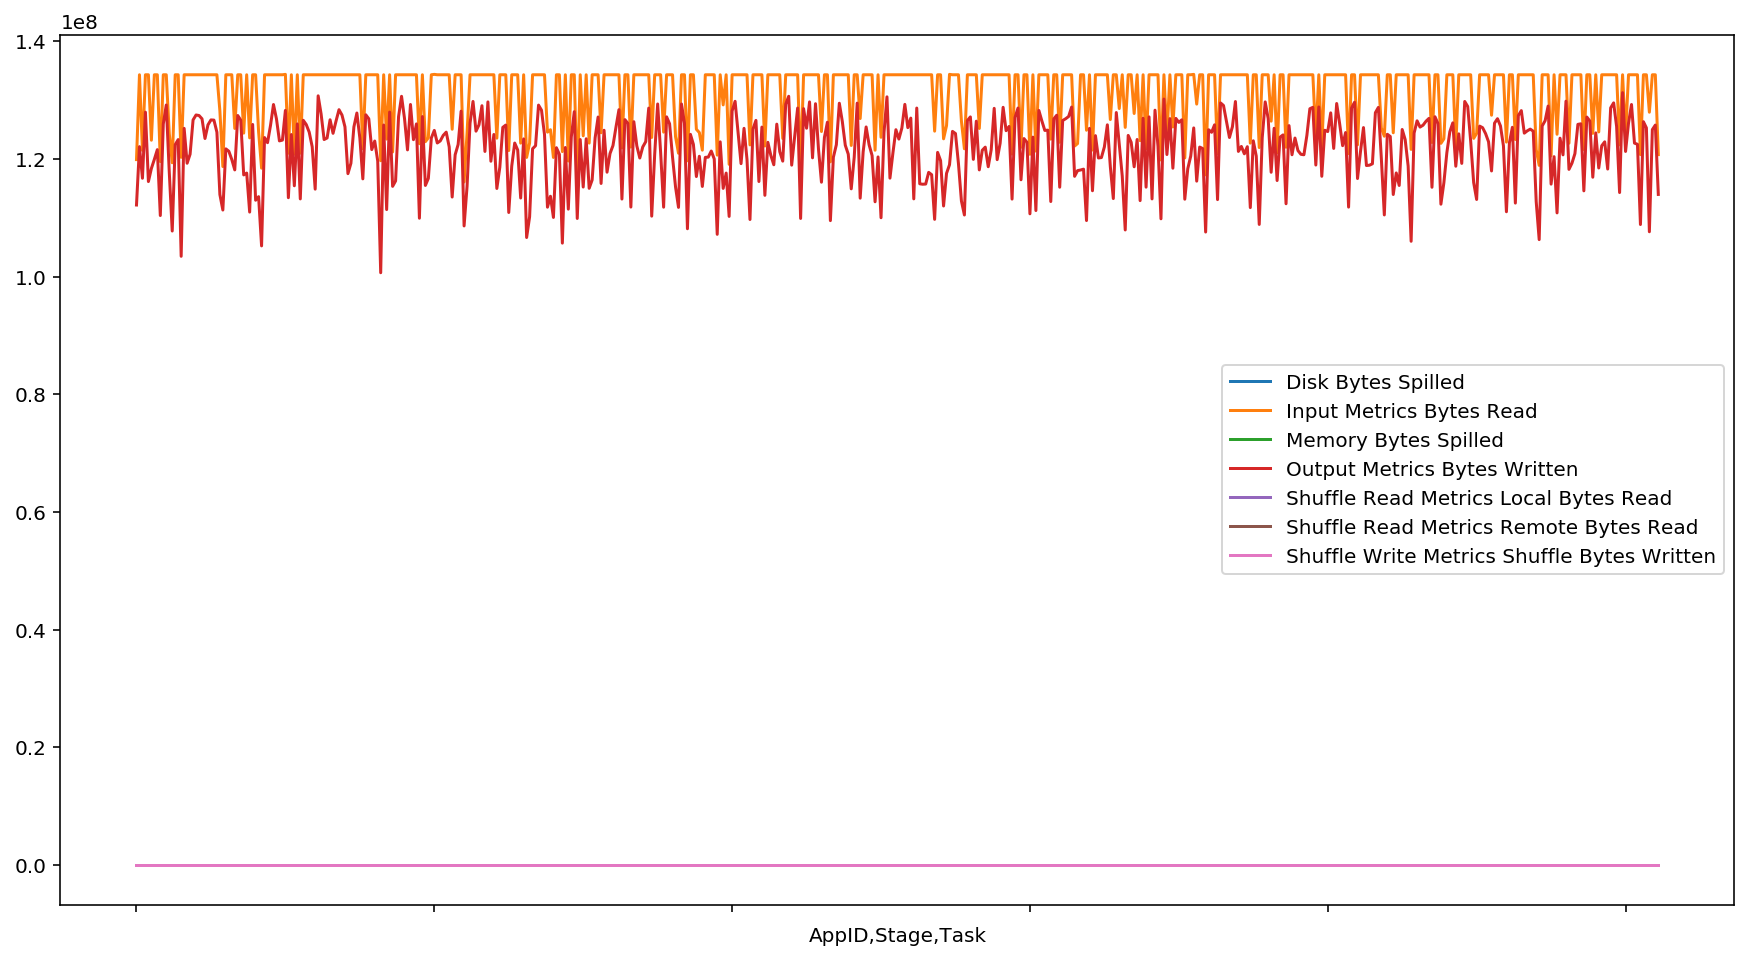

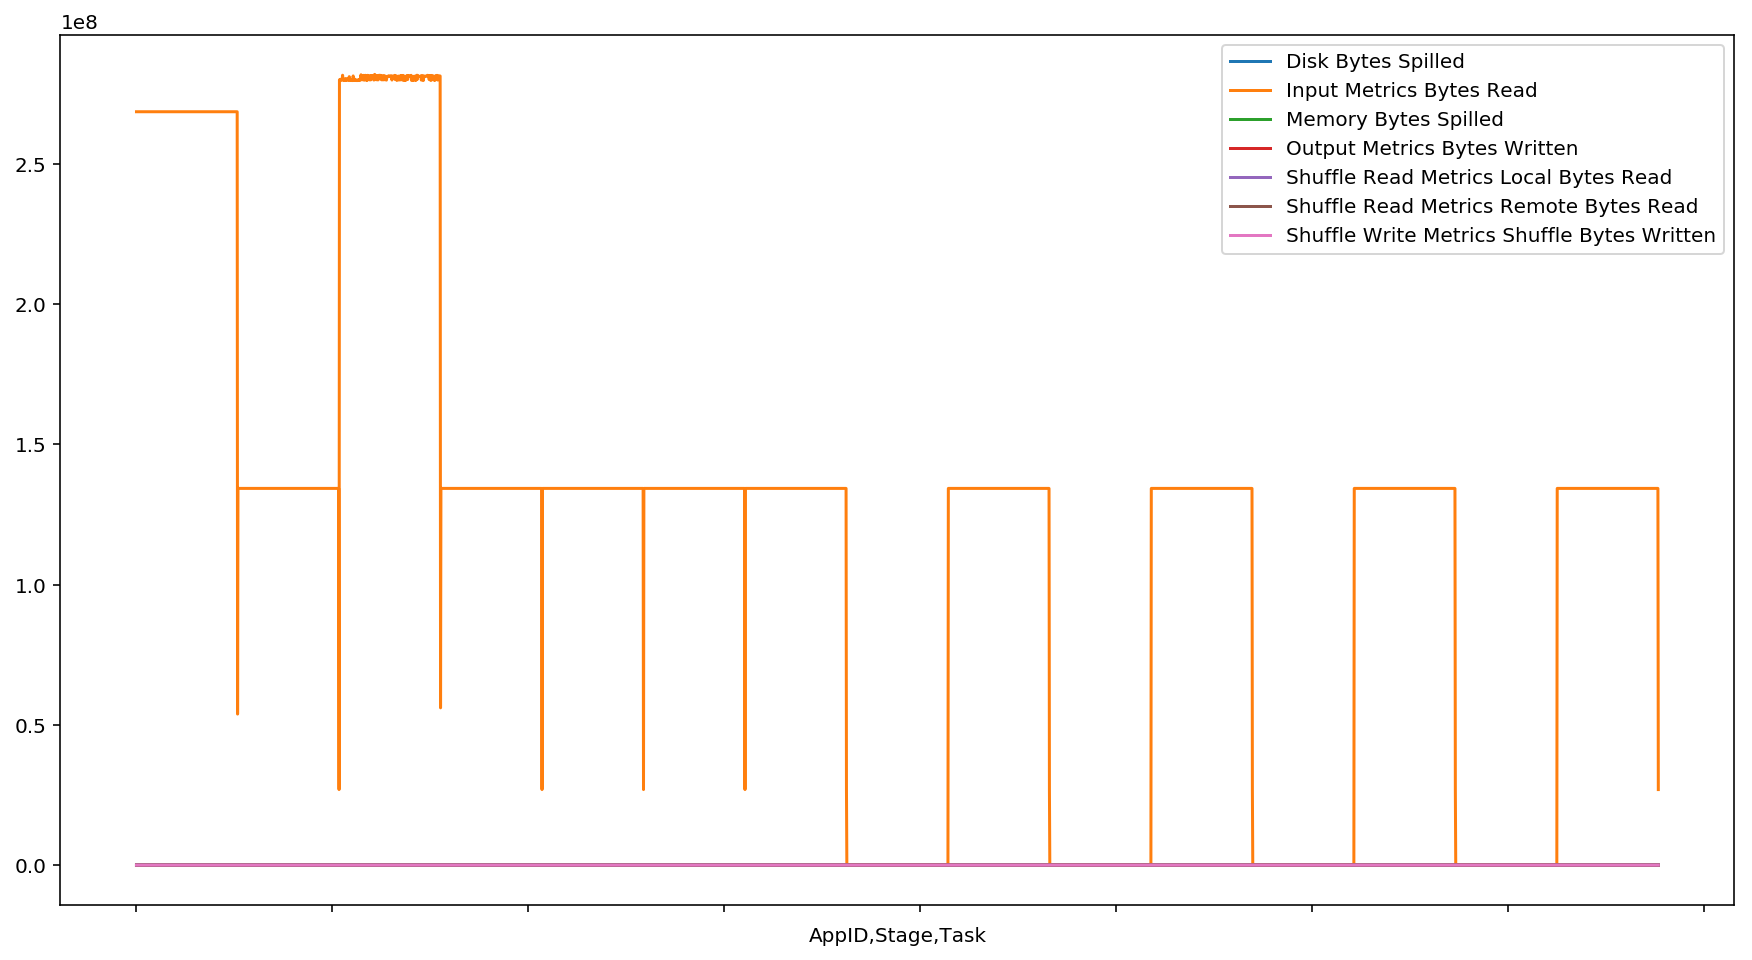

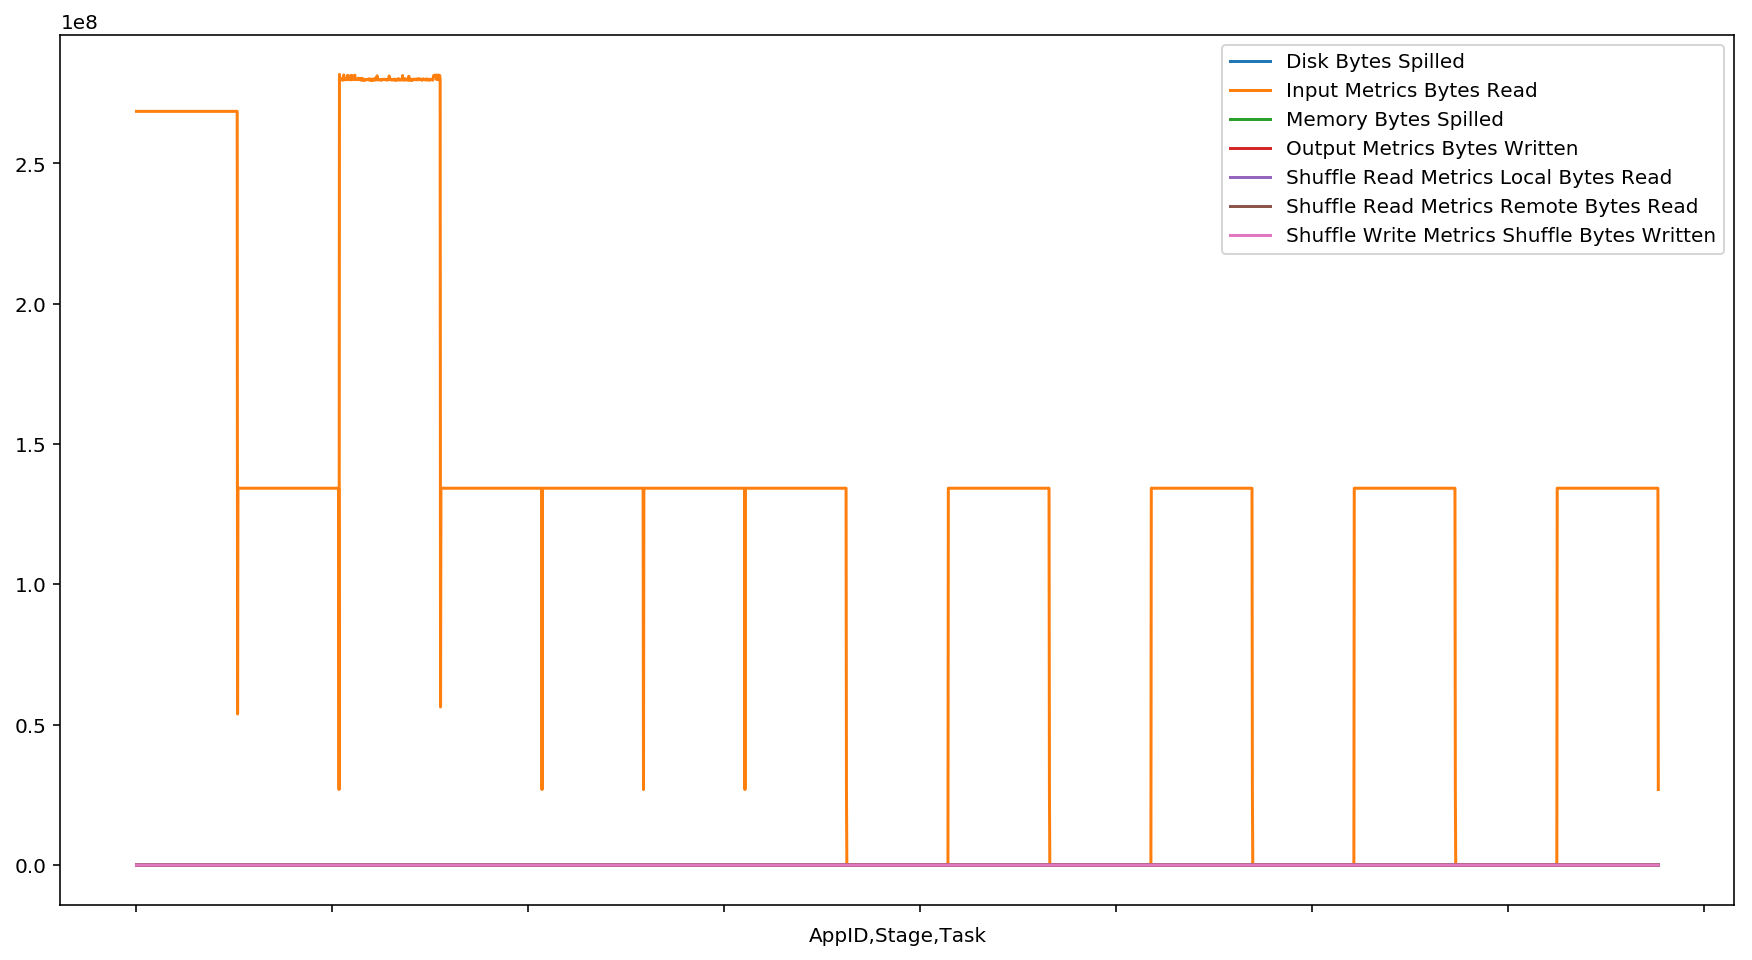

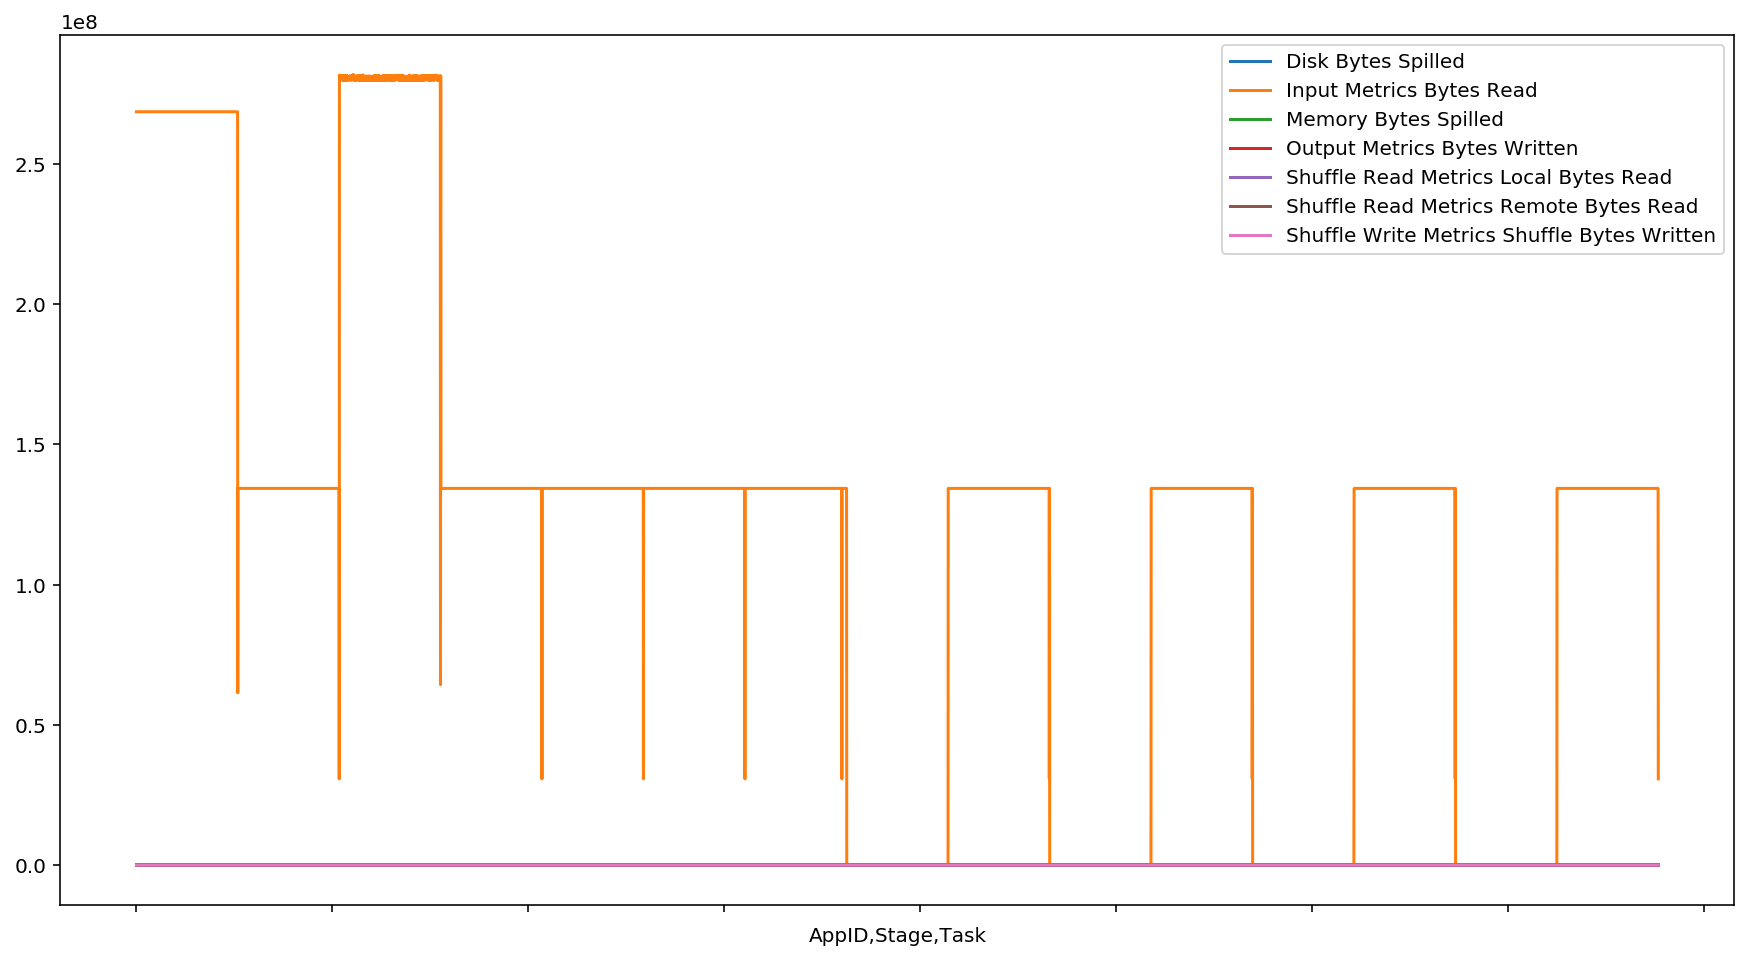

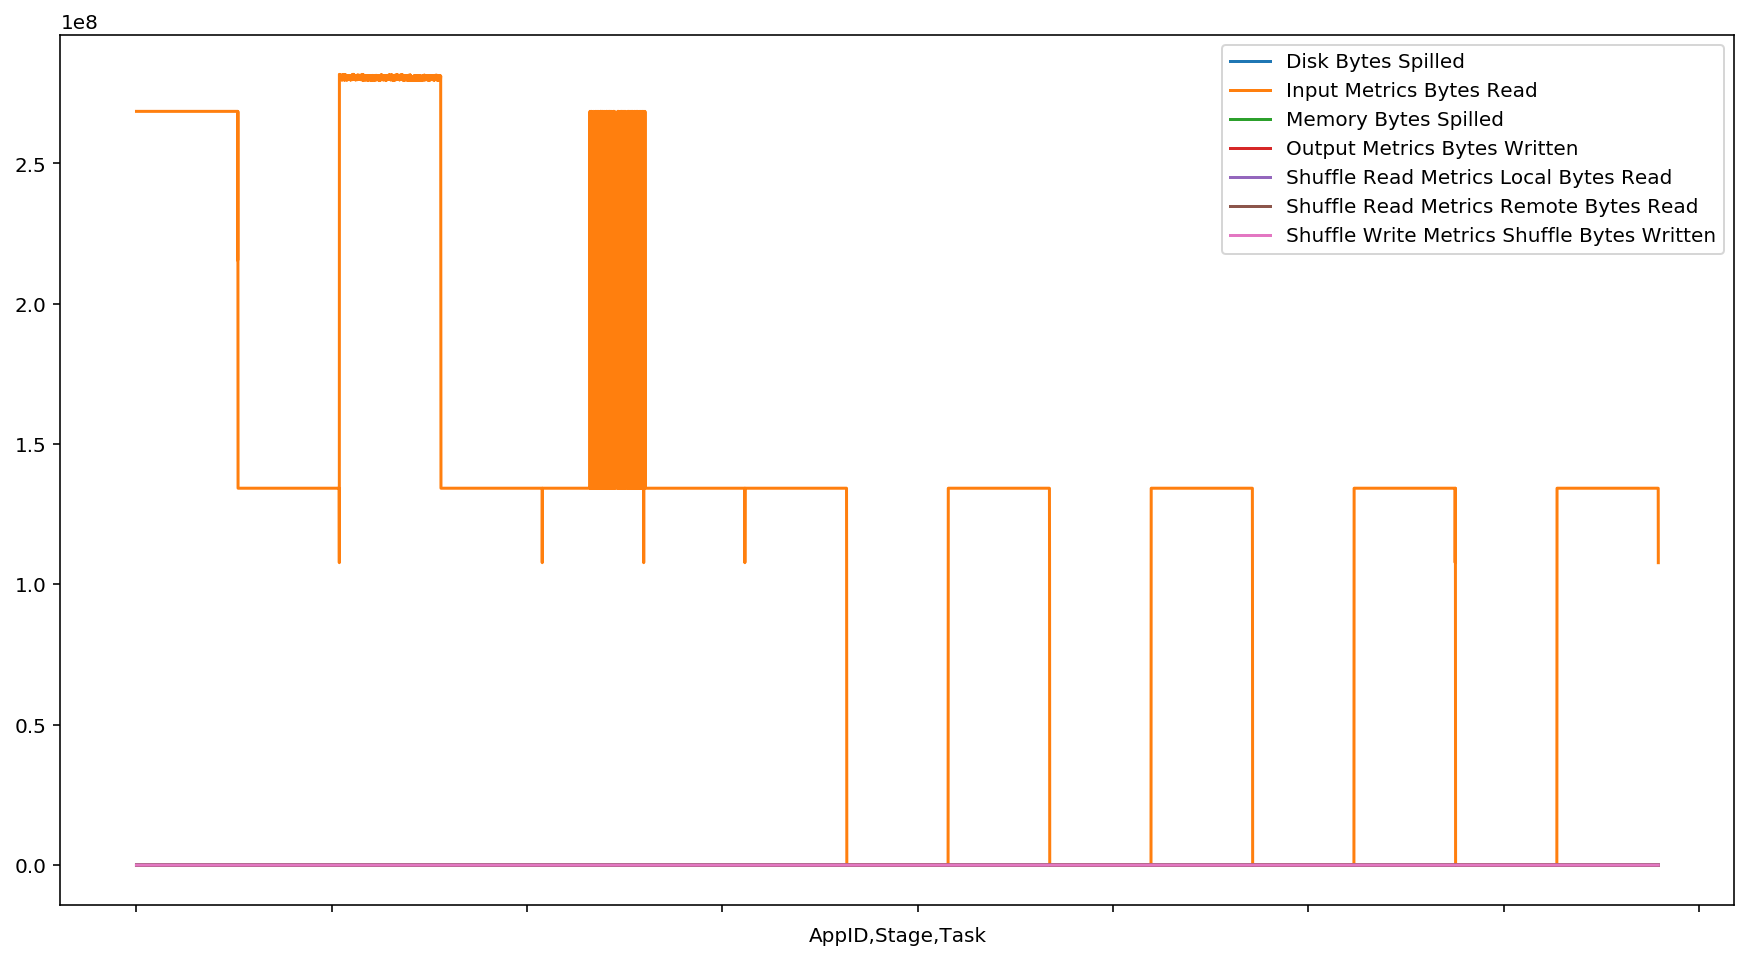

In [64]:
matplotlib.rcParams['figure.figsize'] = 15, 8

bytes_col = [col for col in tasks.columns if "Byte" in col ]#and "Input" not in col ]
tasks[bytes_col].groupby('AppID').plot()
plt.xticks(rotation=90)

Have a look at time spent in each category:

AppID
application_1543954727058_0001    AxesSubplot(0.125,0.125;0.775x0.755)
application_1543954727058_0002    AxesSubplot(0.125,0.125;0.775x0.755)
application_1543954727058_0003    AxesSubplot(0.125,0.125;0.775x0.755)
application_1543954727058_0004    AxesSubplot(0.125,0.125;0.775x0.755)
application_1543954727058_0005    AxesSubplot(0.125,0.125;0.775x0.755)
application_1543954727058_0006    AxesSubplot(0.125,0.125;0.775x0.755)
application_1543954727058_0007    AxesSubplot(0.125,0.125;0.775x0.755)
application_1544104813447_0001    AxesSubplot(0.125,0.125;0.775x0.755)
application_1544104813447_0002    AxesSubplot(0.125,0.125;0.775x0.755)
application_1544444660638_0001    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

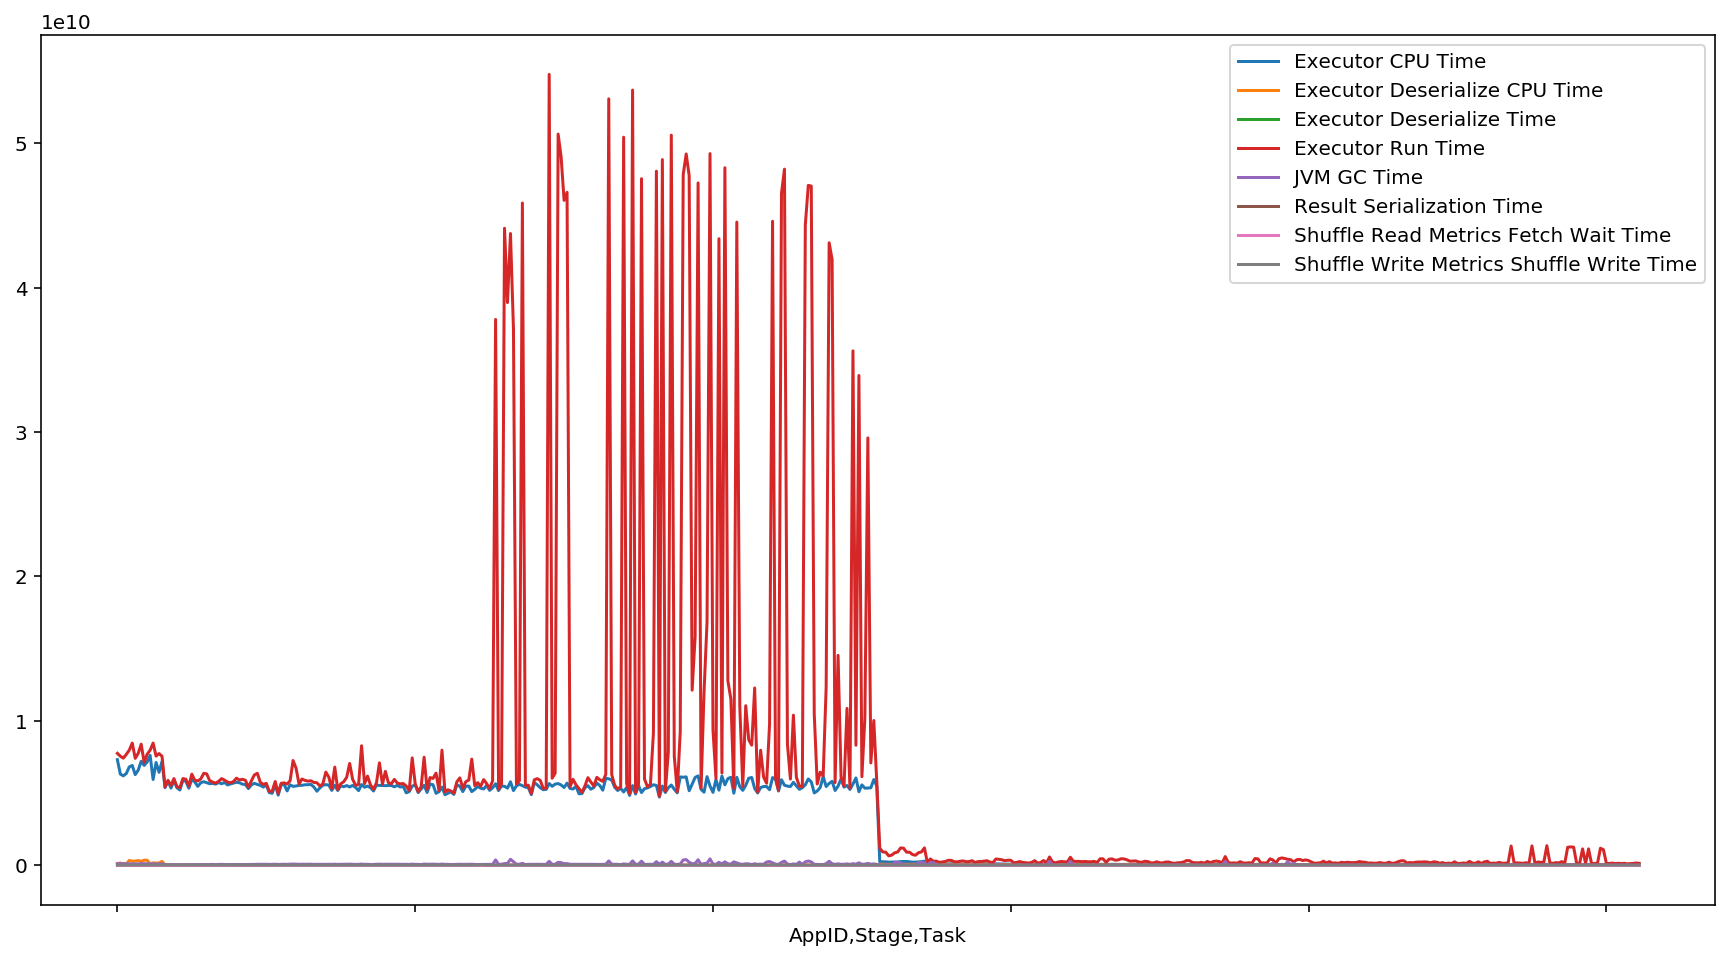

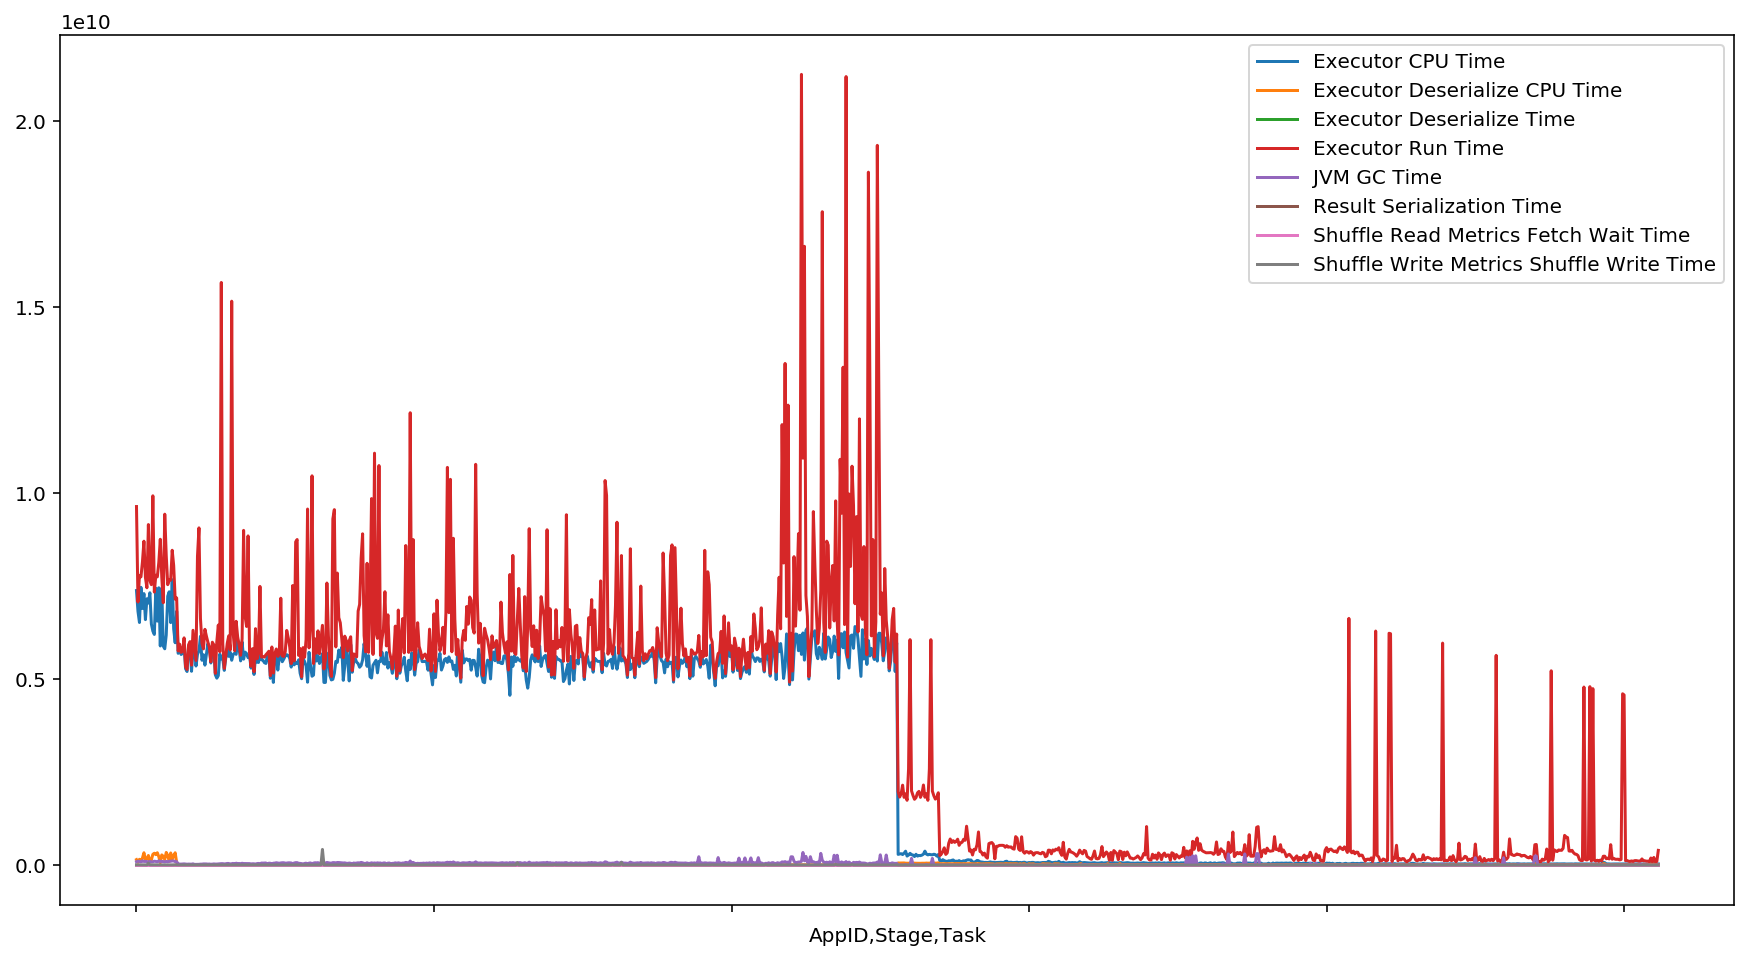

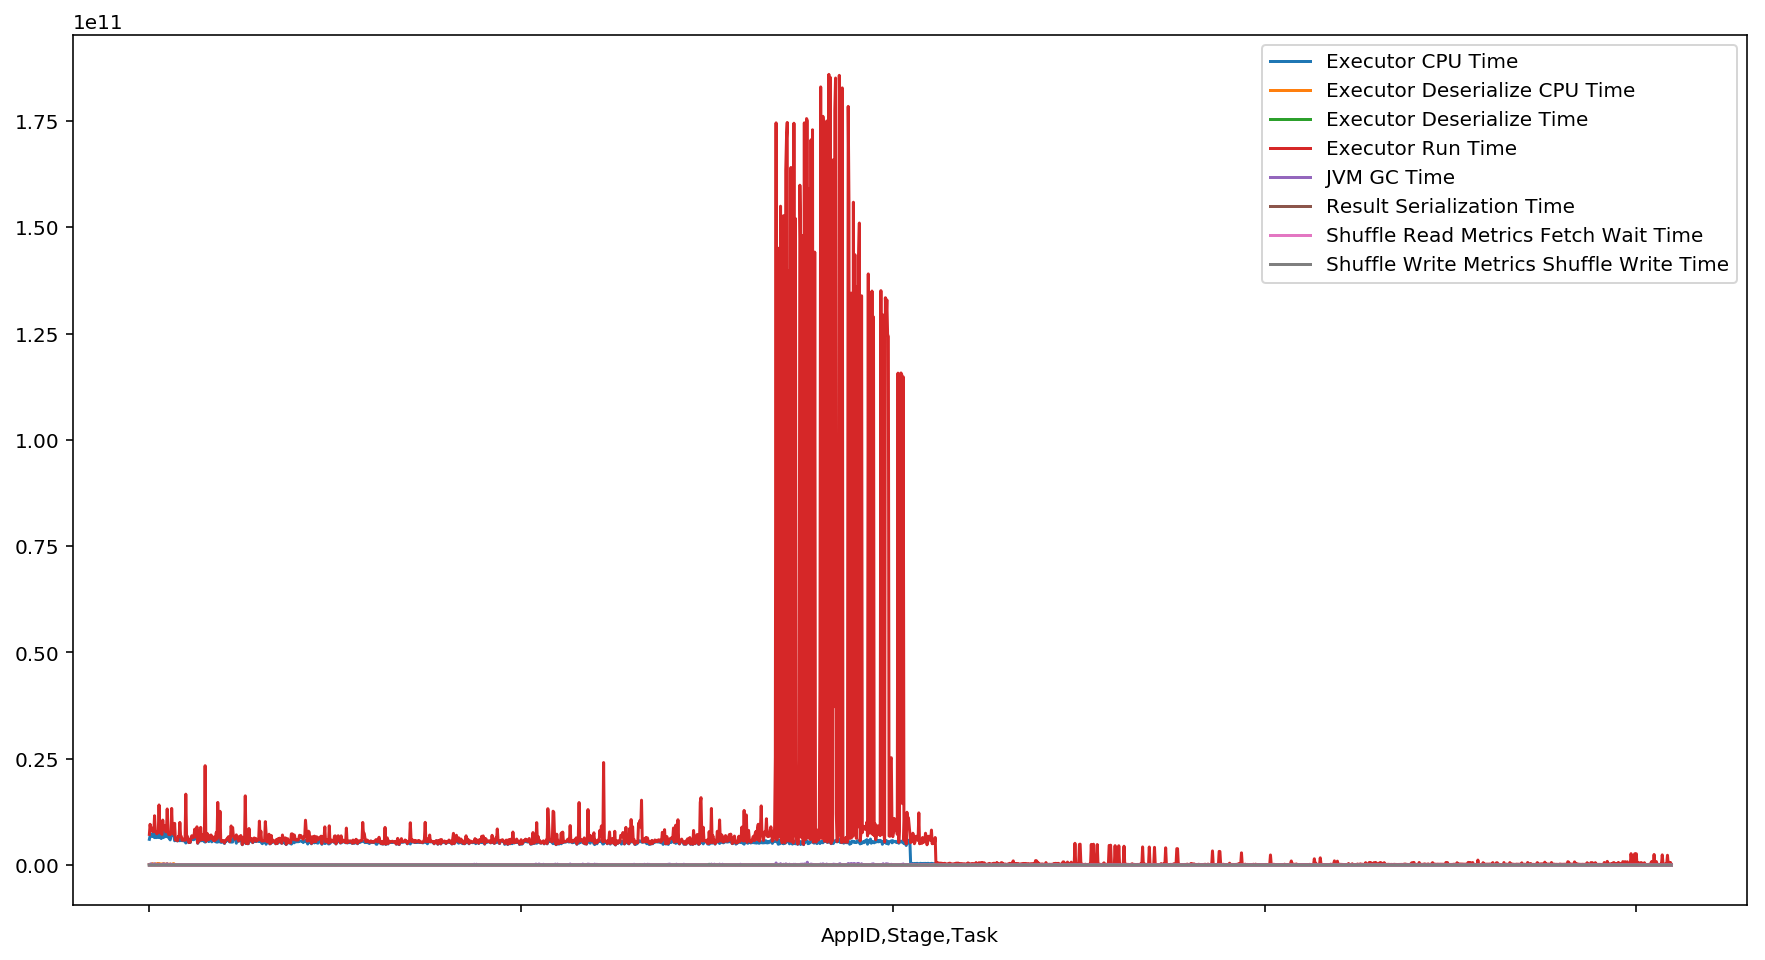

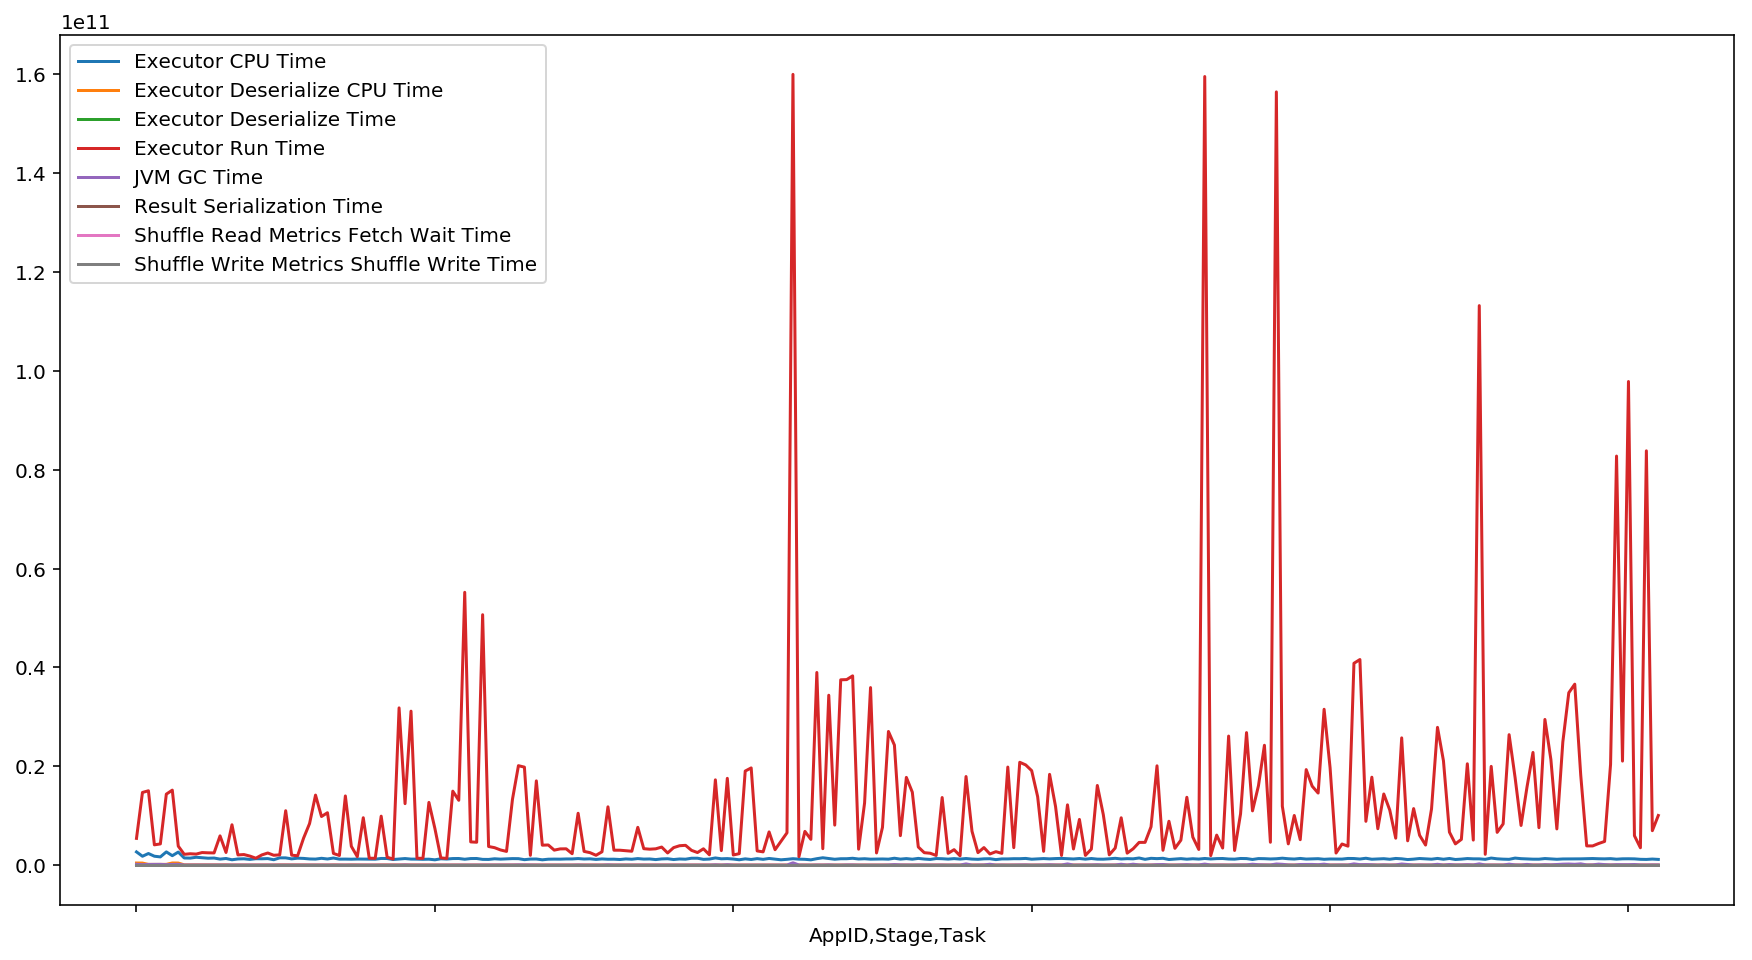

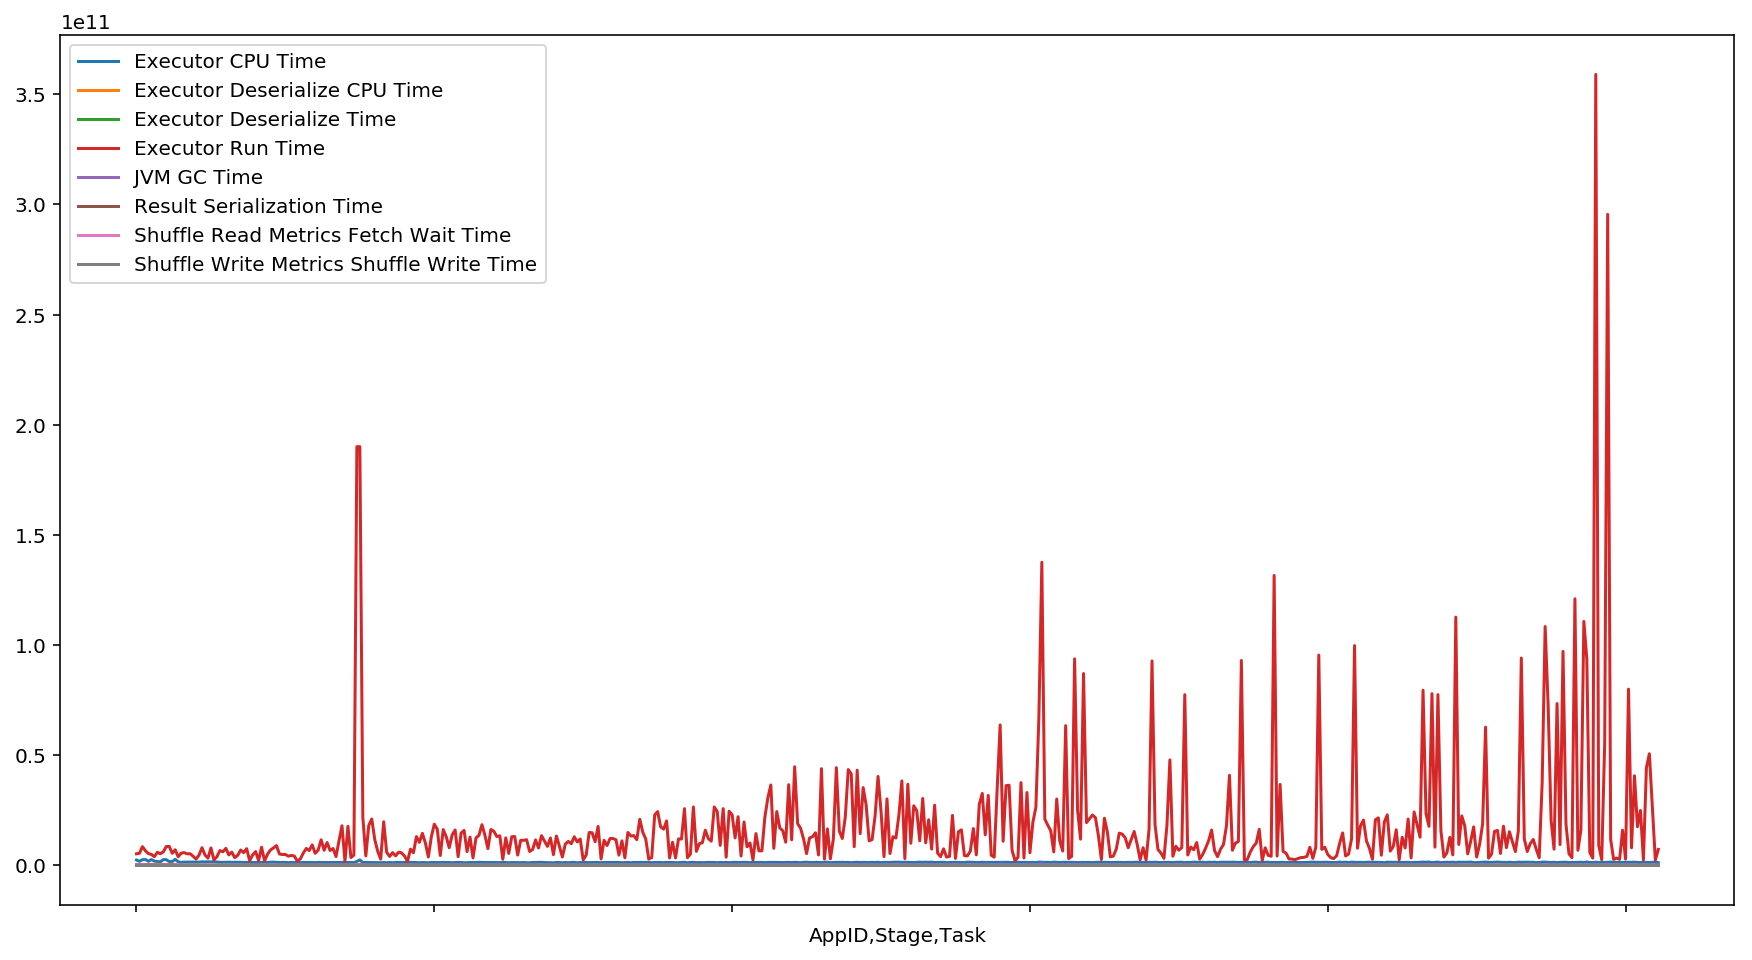

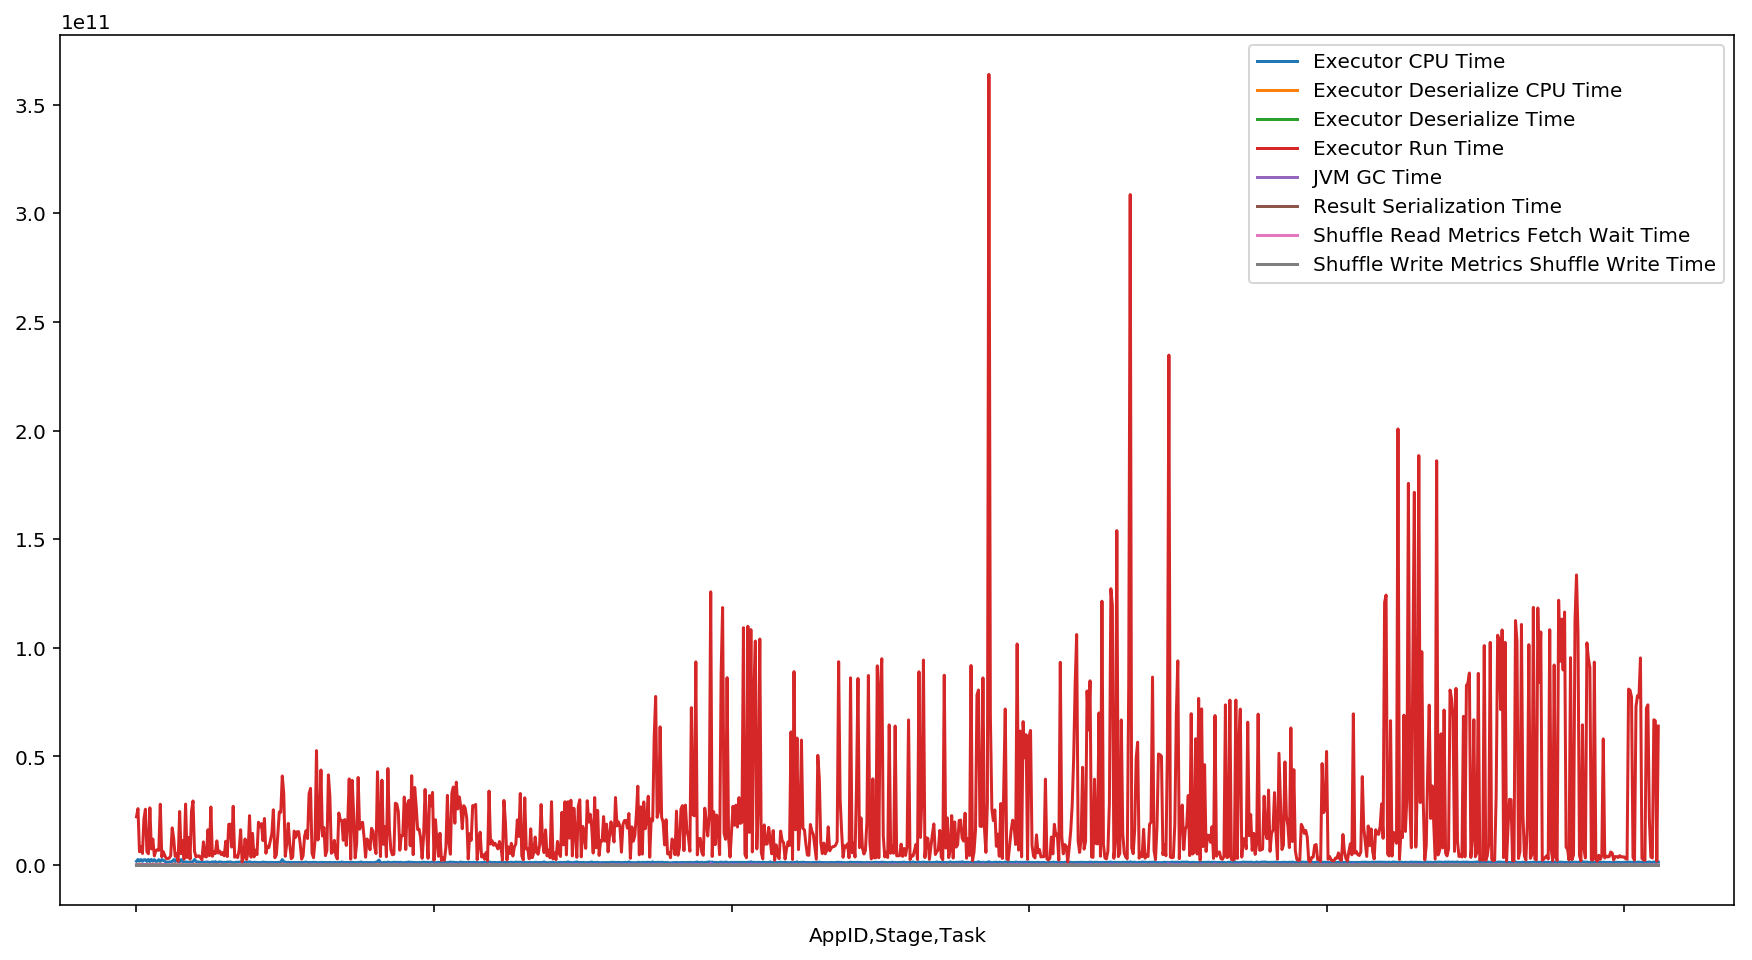

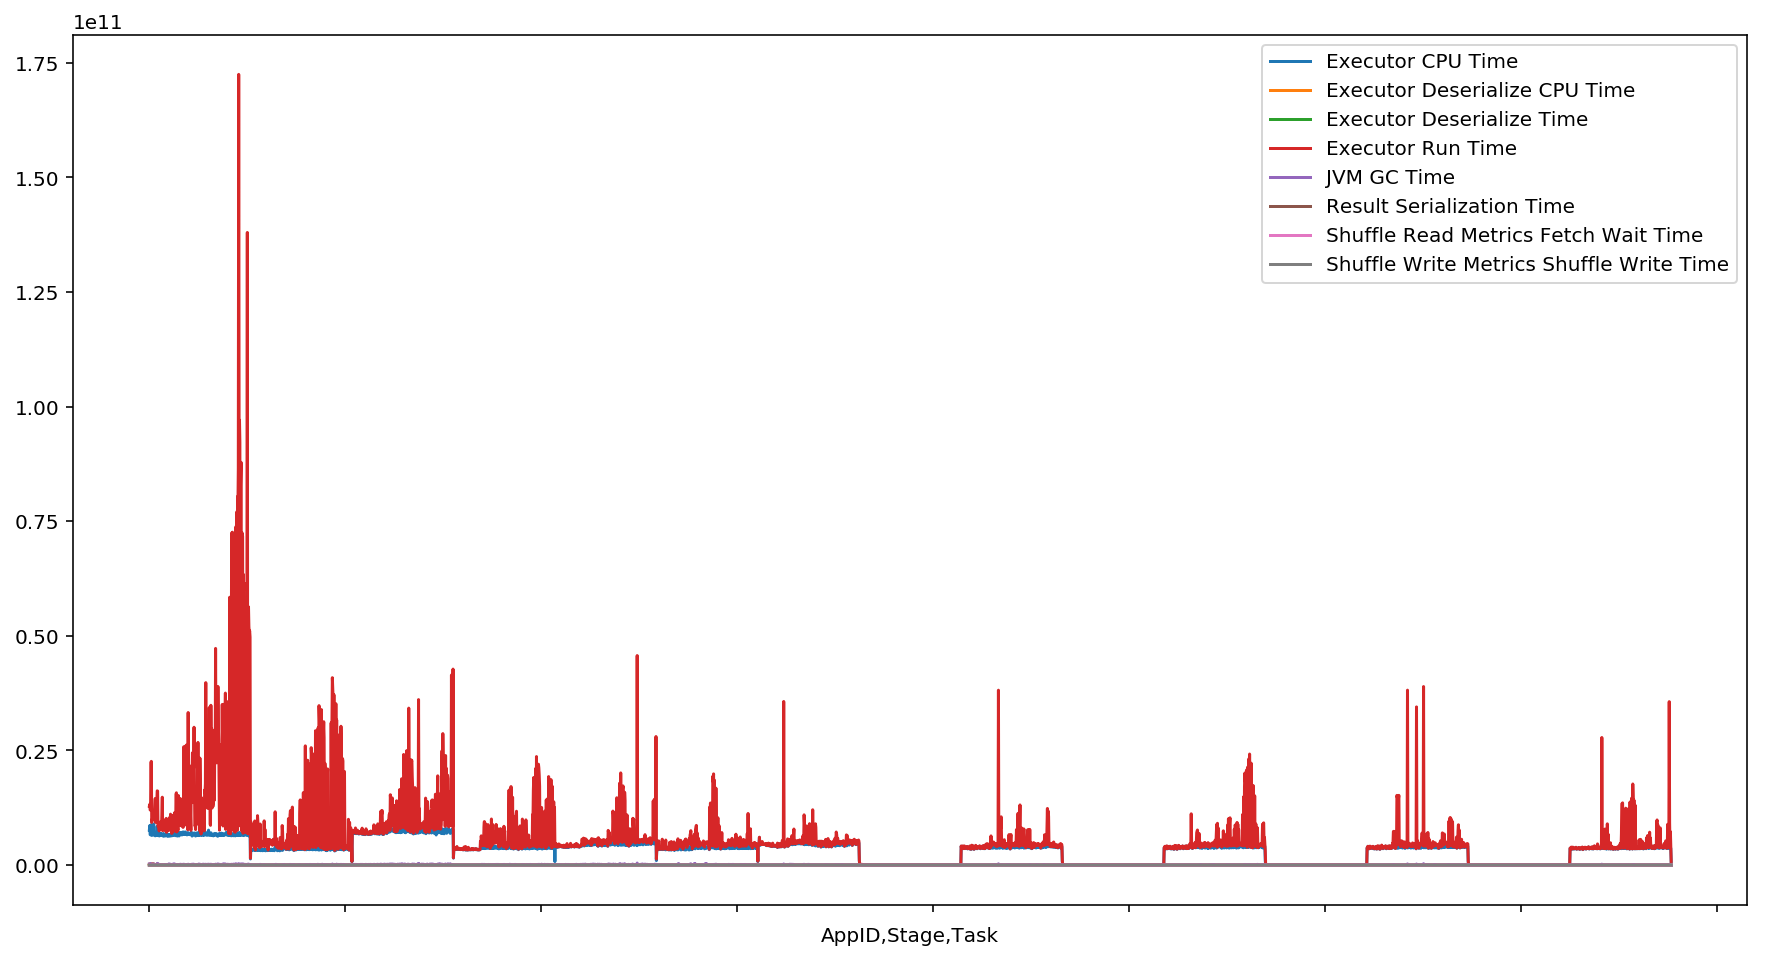

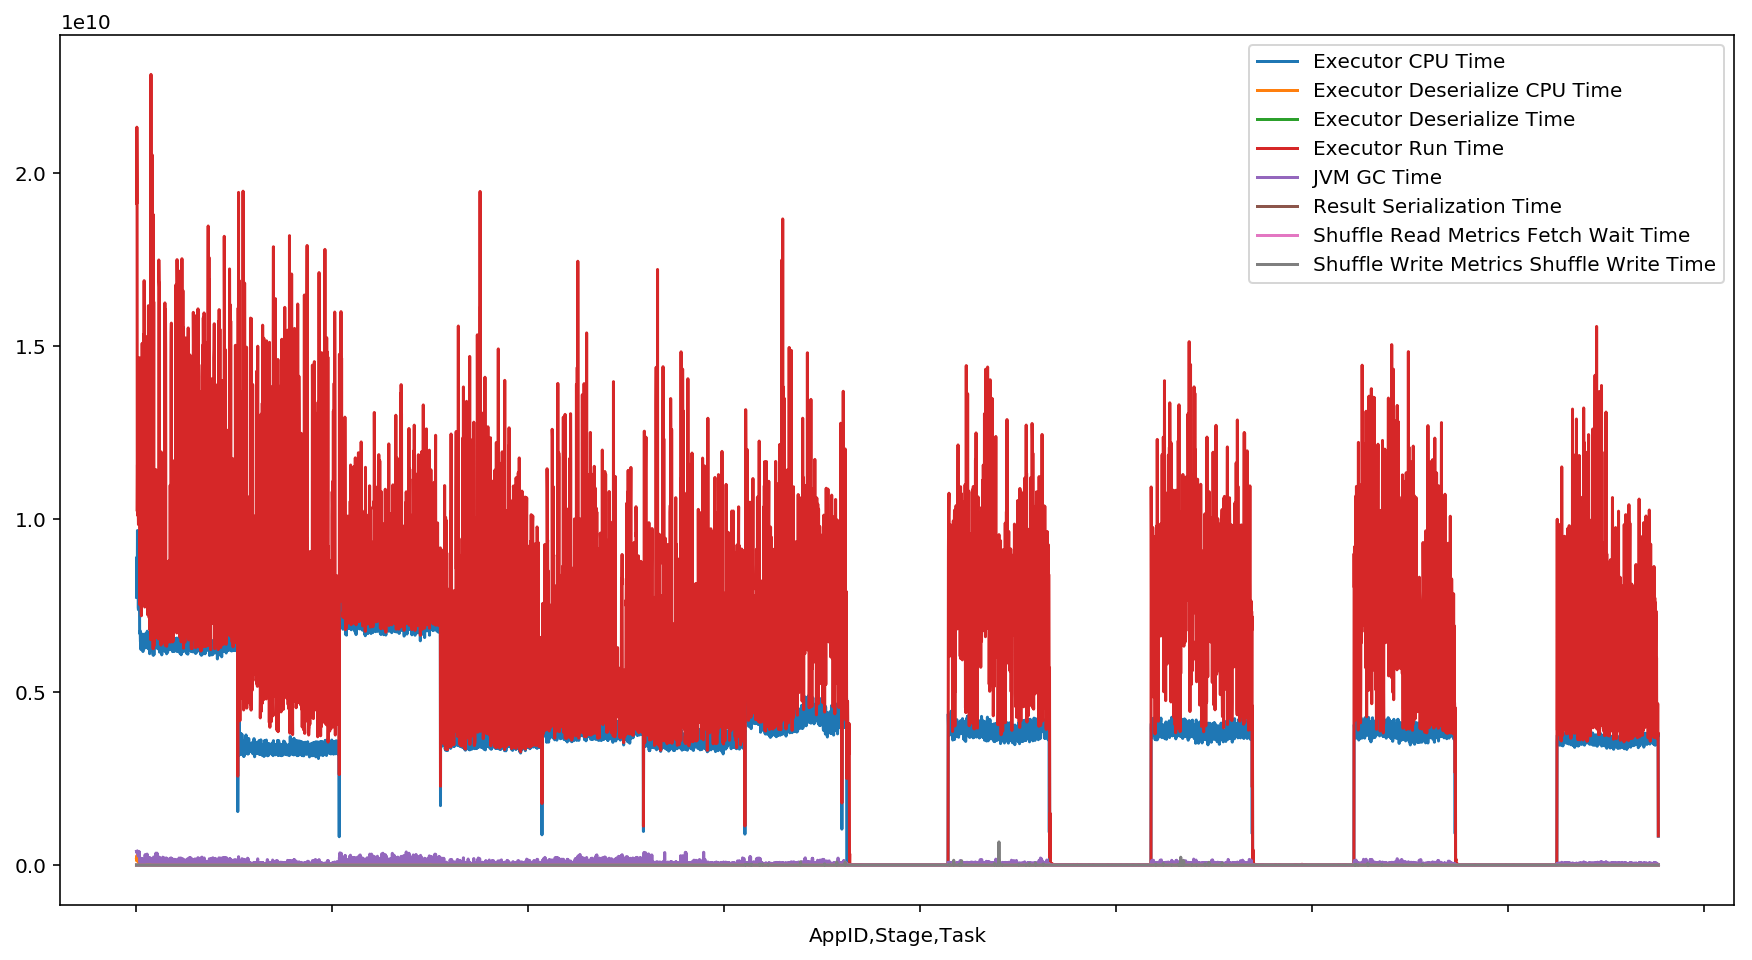

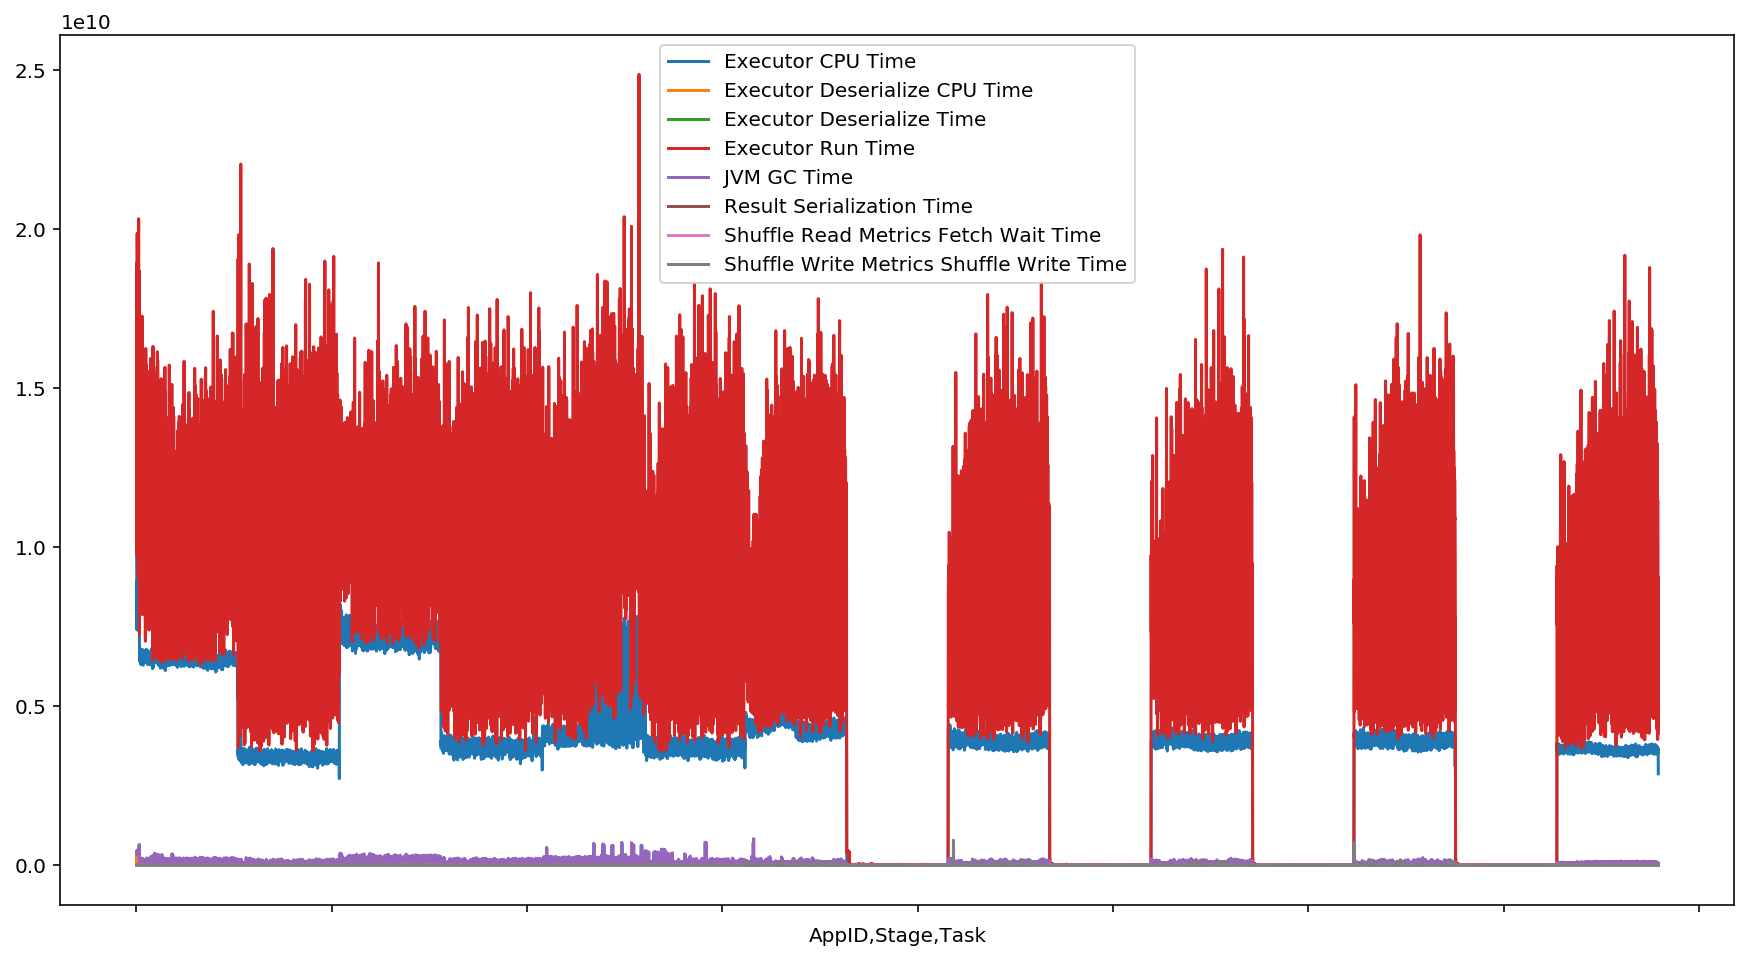

In [22]:
time_col = [col for col in tasks.columns if "Time" in col and "Launch" not in col]
tasks[time_col].groupby('AppID').plot()

## Stages analysis

In [23]:
stages

DFS_input_bytes  DFS_output_bytes                          app_id  \
0      1.346495e+11               NaN  application_1543954727058_0003   
1               NaN      1.321690e+05  application_1543954727058_0003   
2      3.369259e+10               NaN  application_1543954727058_0001   
3               NaN      1.282170e+05  application_1543954727058_0001   
4      1.389103e+11               NaN  application_1544104813447_0002   
5      6.945517e+10               NaN  application_1544104813447_0002   
6      1.450863e+11               NaN  application_1544104813447_0002   
7      6.945517e+10               NaN  application_1544104813447_0002   
8      6.945517e+10               NaN  application_1544104813447_0002   
9      6.945517e+10               NaN  application_1544104813447_0002   
10     6.945517e+10               NaN  application_1544104813447_0002   
11              NaN               NaN  application_1544104813447_0002   
12     6.945517e+10               NaN  application_1544104813447_0002   
13              NaN               NaN  application_1544104813447_0002   
14     6.945517e+10               NaN  application_1544104813447_0002   
15              NaN               NaN  application_1544104813447_0002   
16     6.945517e+10               NaN  application_1544104813447_0002   
17              NaN               NaN  application_1544104813447_0002   
18     6.945517e+10               NaN  application_1544104813447_0002   
19     6.934400e+10               NaN  application_1543954727058_0007   
20     3.467200e+10               NaN  application_1543954727058_0007   
21     7.247199e+10               NaN  application_1543954727058_0007   
22     3.467200e+10               NaN  application_1543954727058_0007   
23     3.467200e+10               NaN  application_1543954727058_0007   
24     3.467200e+10               NaN  application_1543954727058_0007   
25     3.467200e+10               NaN  application_1543954727058_0007   
26              NaN               NaN  application_1543954727058_0007   
27     3.467200e+10               NaN  application_1543954727058_0007   
28              NaN               NaN  application_1543954727058_0007   
29     3.467200e+10               NaN  application_1543954727058_0007   
..              ...               ...                             ...   
39     1.474165e+11               NaN  application_1544444660638_0001   
40     1.397623e+11               NaN  application_1544444660638_0001   
41     1.394938e+11               NaN  application_1544444660638_0001   
42              NaN               NaN  application_1544444660638_0001   
43     1.394938e+11               NaN  application_1544444660638_0001   
44              NaN               NaN  application_1544444660638_0001   
45     1.394938e+11               NaN  application_1544444660638_0001   
46              NaN               NaN  application_1544444660638_0001   
47     1.394938e+11               NaN  application_1544444660638_0001   
48              NaN               NaN  application_1544444660638_0001   
49     1.394938e+11               NaN  application_1544444660638_0001   
50     6.726908e+10               NaN  application_1543954727058_0002   
51              NaN      1.305040e+05  application_1543954727058_0002   
52     1.346495e+11      1.243963e+11  application_1543954727058_0006   
53     6.934400e+10               NaN  application_1544104813447_0001   
54     3.467200e+10               NaN  application_1544104813447_0001   
55     7.230701e+10               NaN  application_1544104813447_0001   
56     3.467200e+10               NaN  application_1544104813447_0001   
57     3.467200e+10               NaN  application_1544104813447_0001   
58     3.467200e+10               NaN  application_1544104813447_0001   
59     3.467200e+10               NaN  application_1544104813447_0001   
60              NaN               NaN  application_1544104813447_0001   
61     3.467200e+10               NaN  application_15441048134

# Generates Batsim job profiles for these Applications

This is for the stage level modele.

Example of output:
```json
{
    "app1":": {
      "type": "composed",
      "seq": ["stage_1", "stage_2"]
    },
    "stage_2": {
      "type": "msg_par_hg_tot",
      "cpu": 6e9,
      "com": 2e5
    },
    "stage_1": {
      "type": "msg_par_hg_tot",
      "cpu": 1e9,
      "com": 2e5
}
```

In [24]:
apps

ANY  NODE_LOCAL  NO_PREF  PROCESS_LOCAL  RACK_LOCAL  \
0    0         847        0           1024         177   
1    0         127        0            256         129   
2    0        5699        0           2067           4   
3    0         779        0           1005        2101   
4    0          71        0              0         185   
5    0       11428        0           4156           1   
6    0         442        0            512          70   
7    0         783        0              0         241   
8    0        2802        0           1009          74   
9    0         282        0              0         230   

                           app_id                app_type  execution_time  \
0  application_1543954727058_0003  BigDataBench WordCount             581   
1  application_1543954727058_0001  BigDataBench WordCount             253   
2  application_1544104813447_0002     BigDataBench KMeans            2659   
3  application_1543954727058_0007     BigDataBench KMeans            3127   
4  application_1543954727058_0004       BigDataBench Grep             511   
5  application_1544444660638_0001     BigDataBench KMeans            4204   
6  application_1543954727058_0002  BigDataBench WordCount             191   
7  application_1543954727058_0006       BigDataBench Grep             886   
8  application_1544104813447_0001     BigDataBench KMeans            2032   
9  application_1543954727058_0005       BigDataBench Grep             884   

  input_dataset_size  longest_task_execution_time  \
0                128                       185949   
1                 32                        54789   
2                 64                        24056   
3                 32                       172504   
4                 32                       160025   
5                128                        24884   
6                 64                        21277   
7                128                       363995   
8                 32                        30697   
9                 64                       359072   

                   ...                    nb_started_stages  nb_started_tasks  \
0                  ...                                    2              2048   
1                  ...                                    2               512   
2                  ...                                   15              7770   
3                  ...                                   15              3885   
4                  ...                                    1               256   
5                  ...                                   15             15585   
6                  ...                                    2              1024   
7                  ...                                    1              1024   
8                  ...                                   15              3885   
9                  ...                                    1               512   

   requested_cores_per_executor  requested_memory_per_executor  \
0                             2                             6g   
1                             2                             6g   
2                             2                             6g   
3                             2                             6g   
4                             2                             6g   
5                             2                             6g   
6                             2                             6g   
7                             2                             6g   
8                             2                             6g   
9                             2                             6g   

   time_in_complete_task  time_in_complete_task_after_filter  \
0               15826377                                   0   
1                3216104                                   0   
2               40996197                                   0   
3               22025997                                 

In [25]:
apps["nb_requested_cores"] = apps["nb_requested_executor"] * apps["requested_cores_per_executor"]

In [26]:
apps["nb_requested_cores"]

0    32
1     8
2    16
3     8
4     8
5    32
6    16
7    32
8     8
9    16
Name: nb_requested_cores, dtype: int64

In [27]:
apps.execution_time

0     581
1     253
2    2659
3    3127
4     511
5    4204
6     191
7     886
8    2032
9     884
Name: execution_time, dtype: int64

## Calibration

The number of flops or "speed" that is given to Simgrid needs to be calibrated depending on the platform given to simgrid and the machine that run the actual simulation.

In [82]:
# WARNING: this value is a guess and should be modified by calibration
flops_per_sec = 5 # 2.5Ghz with 2 thread (apply to nanosecond CPU time)

The value provided by the application metrics is the number of cores but batsim resource request is based on the number of machine. To workaround this problem we need to scale down the resource request depending on the number of cores that are provided by the plateform, here Taurus has 12 cores per node.

In [45]:
nb_core_per_nodes = 4

In [65]:
def get_stage_tasks(tasks, app_id, stage_number):
    app_tasks = tasks[tasks.index.get_level_values("AppID") == app_id]
    return app_tasks[app_tasks.index.get_level_values("Stage") == stage_number]
     
def get_stage_total_flops(tasks, app_id, stage_number):
    stage_tasks = get_stage_tasks(tasks, app_id, stage_number)
    return stage_tasks["Executor CPU Time"].sum()  * flops_per_sec

def get_stage_total_comm(tasks, app_id, stage_number):
    stage_tasks = get_stage_tasks(tasks, app_id, stage_number)
    return stage_tasks['Shuffle Read Metrics Remote Bytes Read'].sum()

def get_stage_total_io(tasks, app_id, stage_number):
    stage_tasks = get_stage_tasks(tasks, app_id, stage_number)
    return stage_tasks['Output Metrics Bytes Written'].sum() + stage_tasks['Input Metrics Bytes Read'].sum()

def get_stage_total_io_reads(tasks, app_id, stage_number):
    stage_tasks = get_stage_tasks(tasks, app_id, stage_number)
    if 'Input Metrics Bytes Read' in stage_tasks.columns:
        return stage_tasks['Input Metrics Bytes Read'].sum()
    return 0
                       
def get_stage_total_io_writes(tasks, app_id, stage_number):
    stage_tasks = get_stage_tasks(tasks, app_id, stage_number)
    if 'Output Metrics Bytes Written' in stage_tasks.columns:
        return stage_tasks['Output Metrics Bytes Written'].sum()     
    return 0

def size_in_string(input_size_in_GB):
    if input_size_in_GB == 32:
        return 'tiny'
    if input_size_in_GB == 64:
        return 'small'
    if input_size_in_GB == 128:
        return 'medium'
    raise 'Input size should be one of these values, 32, 64, 128'

In [66]:
import math

def generate_app_profile(app):
    profile = {
        app["app_type"].split()[1] + "_" + size_in_string(int(app["input_dataset_size"])): { # + "_" + app["app_id"].split("_")[2]: {
          "type": "composed",
          "seq": [app["app_id"] + "_stage_" + str(i) for i in range(app["nb_started_stages"])],
          "application_type": app["app_type"],
          "input_size_in_GB": int(app["input_dataset_size"]),
          "nb_tasks": int(app["nb_necessary_tasks"]),
          "nb_requested_res": int(math.ceil(app["nb_requested_cores"] / nb_core_per_nodes)),
          "execution_time": app["execution_time"]
        },
        **{
            app["app_id"] + "_stage_" + str(i): {
                "type": "parallel_homogeneous_total",
                "nb_tasks": int(list(stages[(stages["app_id"] == app["app_id"]) & (stages["stage_id"] == i)]["nb_tasks"])[0]),
                "cpu": get_stage_total_flops(tasks, app["app_id"], i),
                #"com": get_stage_total_comm(tasks, app["app_id"], i) + get_stage_total_io(tasks, app["app_id"], i),
                # "io": get_stage_total_io(tasks, app["app_id"], i)
                "com": get_stage_total_comm(tasks, app["app_id"], i),
                "io_reads": get_stage_total_io_reads(tasks, app["app_id"], i),
                "io_writes": get_stage_total_io_writes(tasks, app["app_id"], i)
             } for i in range(app.nb_started_stages)
        }
    }
    return profile

In [67]:
profiles = apps.apply(generate_app_profile, axis=1)

In [68]:
profiles

0    {'WordCount_medium': {'type': 'composed', 'seq...
1    {'WordCount_tiny': {'type': 'composed', 'seq':...
2    {'KMeans_small': {'type': 'composed', 'seq': [...
3    {'KMeans_tiny': {'type': 'composed', 'seq': ['...
4    {'Grep_tiny': {'type': 'composed', 'seq': ['ap...
5    {'KMeans_medium': {'type': 'composed', 'seq': ...
6    {'WordCount_small': {'type': 'composed', 'seq'...
7    {'Grep_medium': {'type': 'composed', 'seq': ['...
8    {'KMeans_tiny': {'type': 'composed', 'seq': ['...
9    {'Grep_small': {'type': 'composed', 'seq': ['a...
dtype: object

In [69]:
merged_profiles = { k: v for d in list(profiles) for k, v in d.items() }

In [70]:
merged_profiles

{'Grep_medium': {'application_type': 'BigDataBench Grep',
  'execution_time': 886,
  'input_size_in_GB': 128,
  'nb_requested_res': 8,
  'nb_tasks': 1024,
  'seq': ['application_1543954727058_0006_stage_0'],
  'type': 'composed'},
 'Grep_small': {'application_type': 'BigDataBench Grep',
  'execution_time': 884,
  'input_size_in_GB': 64,
  'nb_requested_res': 4,
  'nb_tasks': 512,
  'seq': ['application_1543954727058_0005_stage_0'],
  'type': 'composed'},
 'Grep_tiny': {'application_type': 'BigDataBench Grep',
  'execution_time': 511,
  'input_size_in_GB': 32,
  'nb_requested_res': 2,
  'nb_tasks': 256,
  'seq': ['application_1543954727058_0004_stage_0'],
  'type': 'composed'},
 'KMeans_medium': {'application_type': 'BigDataBench KMeans',
  'execution_time': 4204,
  'input_size_in_GB': 128,
  'nb_requested_res': 8,
  'nb_tasks': 15585,
  'seq': ['application_1544444660638_0001_stage_0',
   'application_1544444660638_0001_stage_1',
   'application_1544444660638_0001_stage_2',
   'applica

In [71]:
# Fix KMeans profile name: KMeans -> Kmeans
for profile_name in merged_profiles.keys():
    if 'KMeans' in profile_name:
        new_profile_name = "Kmeans_" + profile_name.split("_")[1]
        merged_profiles[new_profile_name] = merged_profiles.pop(profile_name)
merged_profiles

{'Grep_medium': {'application_type': 'BigDataBench Grep',
  'execution_time': 886,
  'input_size_in_GB': 128,
  'nb_requested_res': 8,
  'nb_tasks': 1024,
  'seq': ['application_1543954727058_0006_stage_0'],
  'type': 'composed'},
 'Grep_small': {'application_type': 'BigDataBench Grep',
  'execution_time': 884,
  'input_size_in_GB': 64,
  'nb_requested_res': 4,
  'nb_tasks': 512,
  'seq': ['application_1543954727058_0005_stage_0'],
  'type': 'composed'},
 'Grep_tiny': {'application_type': 'BigDataBench Grep',
  'execution_time': 511,
  'input_size_in_GB': 32,
  'nb_requested_res': 2,
  'nb_tasks': 256,
  'seq': ['application_1543954727058_0004_stage_0'],
  'type': 'composed'},
 'Kmeans_medium': {'application_type': 'BigDataBench KMeans',
  'execution_time': 4204,
  'input_size_in_GB': 128,
  'nb_requested_res': 8,
  'nb_tasks': 15585,
  'seq': ['application_1544444660638_0001_stage_0',
   'application_1544444660638_0001_stage_1',
   'application_1544444660638_0001_stage_2',
   'applica

In [72]:
import json
import numpy

from json import encoder

def default(o):
    if isinstance(o, numpy.int64): return int(o)  
    raise TypeError
    
with open("spark_profiles.json", "w+") as f:
    json.dump(merged_profiles, f, indent=2, sort_keys=True, default=default)

In [73]:
!cat spark_profiles.json

{
  "Grep_medium": {
    "application_type": "BigDataBench Grep",
    "execution_time": 886,
    "input_size_in_GB": 128,
    "nb_requested_res": 8,
    "nb_tasks": 1024,
    "seq": [
      "application_1543954727058_0006_stage_0"
    ],
    "type": "composed"
  },
  "Grep_small": {
    "application_type": "BigDataBench Grep",
    "execution_time": 884,
    "input_size_in_GB": 64,
    "nb_requested_res": 4,
    "nb_tasks": 512,
    "seq": [
      "application_1543954727058_0005_stage_0"
    ],
    "type": "composed"
  },
  "Grep_tiny": {
    "application_type": "BigDataBench Grep",
    "execution_time": 511,
    "input_size_in_GB": 32,
    "nb_requested_res": 2,
    "nb_tasks": 256,
    "seq": [
      "application_1543954727058_0004_stage_0"
    ],
    "type": "composed"
  },
  "Kmeans_medium": {
    "application_type": "BigDataBench KMeans",
    "execution_time": 4204,
    "input_size_in_GB": 128,
    "nb_requested_res": 8,
    "nb_tasks": 15585,
    "seq": [
      "application_154444

# Generate a full workload from the profiles 

Note that the simulator do not have the notion of executor, but real workload resource request are based on a number of executors that was fixed at half of the node resources at that time.

Due to limitation is simgrid, we cannot allocate part of a node, so the resource number is host based in this newly created workloads for simulation instead of executor based (half a host) in real conditions.

## New workload generation (Deprecated method)

That's why the profiles are generated with the same parameters as the real experiment profiles, except for the resource maximum and minimum limits and the `iarrival_lambda` parameter that is divided by two because it depends on the job size in resources.

In [74]:
#for seed in range(1,6):
#    !python ./json_workload_generator.py spark_profiles.json ../workloads/bebida_simul_workloads/workload_seed{seed}_jobs25_with_io_bda.json 15 \
#        --indent 4 \
#        --random_seed {seed} \
#        --job_number 25 \
#        --job_log_size_sigma 3 \
#        --job_iarrival_lambda 25 \
#        --job_iarrival_k 1 \
#        --maximum_power_of_two 3 \
#        --minimum_power_of_two 1

## Reuse old workloads

Here we are taking the old workload that was run in real life and just injects the new profiles into it:

In [75]:
import json
import copy

with open("spark_profiles.json") as f:
    profiles = json.load(f)
    
for seed in range(1,4):
    with open(f"../workloads/bebida_irl_workloads/workload_bigdata_seed{seed}_jobs25_bda.json") as f:
        wl = json.load(f)
    # Divide the number of resource by two because only one executor can be put by node
    for job in wl['jobs']:
        job["res"] = int(job["res"] / 2)
    wl["profiles"] = profiles
    with open(f"../workloads/bebida_simul_workloads/workload_seed{seed}_jobs25_with_io_bda.json", "w") as f:
        json.dump(wl, f, indent=2, sort_keys=True)

In [76]:
!ls -l ../workloads/bebida_simul_workloads/

total 888
-rw-r--r-- 1 mmercier users   862 Jan  7 16:41 workload_ctrlbda_Grep_medium.json
-rw-r--r-- 1 mmercier users   895 Feb 15 12:55 workload_ctrlbda_Grep_medium_bda.json
-rw-r--r-- 1 mmercier users   854 Jan  7 16:41 workload_ctrlbda_Grep_small.json
-rw-r--r-- 1 mmercier users   888 Feb 15 12:55 workload_ctrlbda_Grep_small_bda.json
-rw-r--r-- 1 mmercier users   855 Jan  7 16:41 workload_ctrlbda_Grep_tiny.json
-rw-r--r-- 1 mmercier users   885 Feb 15 12:55 workload_ctrlbda_Grep_tiny_bda.json
-rw-r--r-- 1 mmercier users  5399 Jan  7 16:41 workload_ctrlbda_Kmeans_medium.json
-rw-r--r-- 1 mmercier users  5399 Feb 15 12:55 workload_ctrlbda_Kmeans_medium_bda.json
-rw-r--r-- 1 mmercier users  5359 Jan  7 16:41 workload_ctrlbda_Kmeans_small.json
-rw-r--r-- 1 mmercier users  5365 Feb 15 12:55 workload_ctrlbda_Kmeans_small_bda.json
-rw-r--r-- 1 mmercier users  5364 Jan  7 16:41 workload_ctrlbda_Kmeans_tiny.json
-rw-r--r-- 1 mmercier users  5348 Feb 15 12:55 workload_ctrlbda_Kmeans_tiny_bda

In [77]:
!cat ../workloads/bebida_simul_workloads/workload_seed1_jobs25_with_io_bda.json

{
  "command": "./json_workload_generator.py ./spark_bdb_profiles.json workloads/workload_bigdata_seed1_jobs25.json 32 --indent 4 --random_seed 1 --job_number 25 --job_log_size_sigma 3 --job_iarrival_lambda 50 --job_iarrival_k 1 --maximum_power_of_two 4 --minimum_power_of_two 2",
  "date": "2017-06-22 17:52:28.685896",
  "description": "Namespace(indent=4, inputJSON=<_io.TextIOWrapper name='./spark_bdb_profiles.json' mode='r' encoding='UTF-8'>, job_iarrival_k=1.0, job_iarrival_lambda=50.0, job_log_size_mu=1, job_log_size_sigma=3.0, job_number=25, maximum_job_length=None, maximum_power_of_two=4, minimum_power_of_two=2, outputJSON=<_io.TextIOWrapper name='workloads/workload_bigdata_seed1_jobs25.json' mode='w' encoding='UTF-8'>, random_seed=1, resourcesNumber=32, serial_job_probability=0.25)",
  "jobs": [
    {
      "id": 0,
      "profile": "WordCount_small",
      "res": 4,
      "subtime": 23.870769294892334
    },
    {
      "id": 1,
      "profile": "WordCount_medium",
      "res":

In [78]:
!cat ../workloads/bebida_irl_workloads/workload_bigdata_seed1_jobs25_bda.json

{
    "command": "./json_workload_generator.py ./spark_bdb_profiles.json workloads/workload_bigdata_seed1_jobs25.json 32 --indent 4 --random_seed 1 --job_number 25 --job_log_size_sigma 3 --job_iarrival_lambda 50 --job_iarrival_k 1 --maximum_power_of_two 4 --minimum_power_of_two 2",
    "date": "2017-06-22 17:52:28.685896",
    "description": "Namespace(indent=4, inputJSON=<_io.TextIOWrapper name='./spark_bdb_profiles.json' mode='r' encoding='UTF-8'>, job_iarrival_k=1.0, job_iarrival_lambda=50.0, job_log_size_mu=1, job_log_size_sigma=3.0, job_number=25, maximum_job_length=None, maximum_power_of_two=4, minimum_power_of_two=2, outputJSON=<_io.TextIOWrapper name='workloads/workload_bigdata_seed1_jobs25.json' mode='w' encoding='UTF-8'>, random_seed=1, resourcesNumber=32, serial_job_probability=0.25)",
    "jobs": [
        {
            "id": 0,
            "profile": "WordCount_small",
            "res": 8,
            "subtime": 23.870769294892334
        },
        {
            "id": 1,